<a href="https://colab.research.google.com/github/MatiasNazareth1993-coder/Virtual-cell/blob/main/Virtual_Cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def build_surrogate(model, scaler, dataset, metric_fn, n_samples=2000):
    """
    metric_fn(samples) -> scalar metric (e.g., percent time in band)
    dataset: generator of (seq, cond, ct_idx) samples to use as conditioning seeds
    """
    X = []
    y = []
    cnt = 0
    for seq, cond, ct_idx in dataset:
        if cnt >= n_samples: break
        # sample multiple trajectories conditioned on this cond
        samples = p_sample_loop(model, scaler, (4, SEQ_LEN), cond_global=cond.unsqueeze(0).to(device), guidance_scale=1.0)
        # compute metric on sampled trajectories
        metric_vals = [metric_fn(s) for s in samples]
        # aggregate: mean metric
        y.append(np.mean(metric_vals))
        # flatten cond into vector for surrogate features (or include summary stats of seq)
        feat = cond.mean(axis=0).cpu().numpy() if cond.numel() else np.zeros(1)
        X.append(feat)
        cnt += 1
    X = np.vstack(X)
    y = np.array(y)
    # train small decision tree
    tree = DecisionTreeRegressor(max_depth=4)
    tree.fit(X, y)
    print("Tree rules:\n", export_text(tree, feature_names=[f"cond_{i}" for i in range(X.shape[1])]))
    # optionally a random forest for better fidelity
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X, y)
    return tree, rf

In [ ]:
def percent_time_in_band(sample, lower=13500, upper=16500):
    return ((sample >= lower) & (sample <= upper)).mean()

In [ ]:
from sklearn.linear_model import LinearRegression

def lime_local_surrogate(model, scaler, cond, neighbourhood=50):
    """
    Fit a linear surrogate mapping condition → metric in local neighborhood around cond.
    """
    base_cond = cond.cpu().numpy().flatten()
    samples_cond = []
    samples_metric = []
    for _ in range(neighbourhood):
        pert = base_cond + np.random.normal(0, 0.05, size=base_cond.shape)
        samp = p_sample_loop(model, scaler, (1, SEQ_LEN), cond_global=torch.tensor(pert).unsqueeze(0).to(device), guidance_scale=1.0)
        m = percent_time_in_band(samp[0])
        samples_cond.append(pert)
        samples_metric.append(m)
    lr = LinearRegression().fit(np.vstack(samples_cond), np.array(samples_metric))
    return lr.coef_, lr.intercept_

In [ ]:
def permutation_importance(model, scaler, base_cond, metric_fn, n_rounds=50):
    base_sample = p_sample_loop(model, scaler, (1, SEQ_LEN), cond_global=base_cond.unsqueeze(0).to(device), guidance_scale=1.0)[0]
    base_metric = metric_fn(base_sample)
    importances = np.zeros(base_cond.numel())
    for j in range(base_cond.numel()):
        vals = []
        for _ in range(n_rounds):
            pert = base_cond.clone()
            pert[j] = torch.randn_like(pert[j])  # randomize feature j
            samp = p_sample_loop(model, scaler, (1, SEQ_LEN), cond_global=pert.unsqueeze(0).to(device), guidance_scale=1.0)[0]
            vals.append(metric_fn(samp))
        importances[j] = base_metric - np.mean(vals)
    return importances

In [ ]:
import pandas as pd
import numpy as np
import os

# 1. Load the CSV file
in_csv_path = "/mnt/data/telomere_time_series_signal.csv"
df_original = pd.read_csv(in_csv_path)

# Identify the adult stem cell column and its associated signal/telomerase columns
# Exclude signal, telomerase, and processed length columns from `cell_cols` so they are not melted as 'cell_type' columns.
cell_cols = [c for c in df_original.columns if c not in ["division"] and not c.endswith(('_signal', '_telomerase_active', '_with_signal'))]
adult_stem_col_name = next((c for c in cell_cols if "Adult_stem" in c), None)

if adult_stem_col_name is None:
    raise ValueError("Could not find adult stem cell column in CSV.")

signal_col_name_in_original = adult_stem_col_name + "_signal"
telomerase_active_col_name_in_original = adult_stem_col_name + "_telomerase_active"
processed_length_col_name_in_original = adult_stem_col_name + "_with_signal"

# Prepare a DataFrame for melting where the Adult_stem_cell's telomere length column
# points to its processed length (e.g., '_with_signal' values).
df_for_melting = df_original[cell_cols + ['division']].copy()
df_for_melting[adult_stem_col_name] = df_original[processed_length_col_name_in_original] # Overwrite with processed length

# 3. Melt the DataFrame to convert it from wide format to long format
df_long_final = df_for_melting.melt(id_vars=["division"], var_name="cell_type", value_name="telomere_length_bp")

# Rename 'division' to 'time'
df_long_final = df_long_final.rename(columns={"division": "time"})

# 4. Initialize the signal and telomerase active columns to zero for all rows
df_long_final["Adult_stem_cell_signal"] = 0.0
df_long_final["Adult_stem_cell_telomerase_active"] = 0

# 5. Populate these columns only for Adult_stem_cell rows
# Get the signal and telomerase active data aligned by 'time' from the original dataframe
signal_values_from_original = df_original.set_index('division')[signal_col_name_in_original]
telomerase_active_values_from_original = df_original.set_index('division')[telomerase_active_col_name_in_original]

# Create a mask for Adult_stem_cell rows
mask_adult_stem = df_long_final['cell_type'] == adult_stem_col_name

# Map the signal and telomerase active values to the corresponding 'Adult_stem_cell' rows
df_long_final.loc[mask_adult_stem, "Adult_stem_cell_signal"] = df_long_final.loc[mask_adult_stem, 'time'].map(signal_values_from_original)
df_long_final.loc[mask_adult_stem, "Adult_stem_cell_telomerase_active"] = df_long_final.loc[mask_adult_stem, 'time'].map(telomerase_active_values_from_original)

# Generate unique cell_id for each cell_type
cell_type_to_id = {ct_name: i for i, ct_name in enumerate(df_long_final['cell_type'].unique())}
df_long_final['cell_id'] = df_long_final['cell_type'].map(cell_type_to_id)

# Reorder columns as requested
df_long_final = df_long_final[['cell_id', 'time', 'telomere_length_bp', 'cell_type', 'Adult_stem_cell_signal', 'Adult_stem_cell_telomerase_active']]

# 6. Save the resulting long-format DataFrame
out_csv_path = "/mnt/data/processed_telomere_data_for_cvae.csv"
df_long_final.to_csv(out_csv_path, index=False)

print(f"Processed data saved to {out_csv_path}")
print("First 5 rows of the processed DataFrame:")
print(df_long_final.head())

Processed data saved to /mnt/data/processed_telomere_data_for_cvae.csv
First 5 rows of the processed DataFrame:
   cell_id  time  telomere_length_bp        cell_type  Adult_stem_cell_signal  \
0        0     0        12000.000000  Adult_stem_cell                0.006954   
1        0     1        11972.343114  Adult_stem_cell                0.000000   
2        0     2        11943.819580  Adult_stem_cell                0.000000   
3        0     3        11899.877493  Adult_stem_cell                0.049528   
4        0     4        11859.871774  Adult_stem_cell                0.000000   

   Adult_stem_cell_telomerase_active  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0  


In [ ]:
import os
import math
import random
from typing import Optional
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

# ---------------------------
# Config / advanced hyperparams
# ---------------------------
DATA_PATH = "/mnt/data/processed_telomere_data_for_cvae.csv"  # change to your CSV
OUT_DIR = "./checkpoints"
os.makedirs(OUT_DIR, exist_ok=True)

SEQ_LEN = 101                # time-series length (must match dataset)
BATCH_SIZE = 4               # Reduced batch size to match small dataset size
LATENT_DIM = 64
HIDDEN_DIM = 256
NUM_LAYERS = 2
# COND_DIM adjusted dynamically
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 150
KL_ANNEAL_STEPS = 2000      # number of optimizer steps to anneal KL from 0 -> 1
GRAD_CLIP = 1.0
WARMUP_STEPS = 200
SCHEDULER = "cosine"        # choices: "cosine", "linear"
BETA = 1.0                  # final weight of KLD term (with annealing)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MIXED_PRECISION = True      # use AMP for faster training on modern GPUs
SAVE_EVERY = 5              # save checkpoint every N epochs
SEED = 42

# reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ---------------------------
# Data utilities
# ---------------------------
class TelomereSeqDataset(Dataset):
    def __init__(self, df, seq_len, scaler=None, cond_cols=None):
        """
        df: pandas DataFrame with columns ['cell_id','time','telomere_length_bp', ...]
            grouped by cell_id with time from 0..seq_len-1
        cond_cols: list of additional per-time columns to use as conditioning (e.g., 'signal', 'immortal_flag')
        scaler: sklearn scaler fitted on telomere_length_bp values (global)
        """
        self.seq_len = seq_len
        self.cond_cols = cond_cols or []
        self.sequences = []   # list of (seq: [seq_len], cond: [seq_len, cond_dim], meta_dict)
        # group and collect sequences per cell_id
        for cid, g in df.groupby("cell_id"):
            g_sorted = g.sort_values("time")
            if len(g_sorted) < seq_len:
                continue  # skip short series; you could pad or sample otherwise
            seq = g_sorted["telomere_length_bp"].values[:seq_len].astype(np.float32)
            cond = None
            if self.cond_cols:
                cond = g_sorted[self.cond_cols].values[:seq_len].astype(np.float32)  # shape (seq_len, cond_dim)
            self.sequences.append((seq, cond))
        # scaler: fit if not provided
        if scaler is None:
            allvals = np.concatenate([s for s,_ in self.sequences]).reshape(-1,1)
            self.scaler = StandardScaler().fit(allvals)
        else:
            self.scaler = scaler
        # normalize
        self.sequences = [(self.scaler.transform(s.reshape(-1,1)).flatten(), c) for s,c in self.sequences]

    def __len__(self): return len(self.sequences)

    def __getitem__(self, idx):
        seq, cond = self.sequences[idx]
        # return torch tensors: seq shape (seq_len,), cond shape (seq_len, cond_dim) or zeros
        seq_t = torch.from_numpy(seq).float()
        if self.cond_cols:
            cond_t = torch.from_numpy(cond).float()
        else:
            cond_t = torch.zeros(self.seq_len, 0).float()
        return seq_t, cond_t

def collate_fn(batch):
    seqs = torch.stack([b[0] for b in batch], dim=0)                 # (B, T)
    conds = torch.stack([b[1] for b in batch], dim=0) if batch[0][1].numel() else torch.empty(len(batch), SEQ_LEN, 0)
    return seqs, conds

# ---------------------------
# Model: LSTM CVAE (encoder -> mu/logvar -> decode with LSTM)
# ---------------------------
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim=1, cond_dim=0, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=LATENT_DIM):
        super().__init__()
        self.input_dim = input_dim
        self.cond_dim = cond_dim
        self.lstm = nn.LSTM(input_size=input_dim + cond_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=False)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, cond):
        # x: (B, T), cond: (B, T, cond_dim)
        x_in = x.unsqueeze(-1)  # (B, T, 1)
        current_cond_dim = (cond.size(-1) if cond.numel() else 0)
        if current_cond_dim > 0:
            x_in = torch.cat([x_in, cond], dim=-1)  # (B,T,1+cond_dim)
        out, (h_n, c_n) = self.lstm(x_in)  # out: (B,T,hidden_dim)
        h_final = out[:, -1, :]            # (B, hidden_dim)
        mu = self.fc_mu(h_final)
        logvar = self.fc_logvar(h_final)
        return mu, logvar

class DecoderLSTM(nn.Module):
    def __init__(self, output_dim=1, cond_dim=0, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=LATENT_DIM, seq_len=SEQ_LEN):
        super().__init__()
        self.cond_dim = cond_dim
        self.seq_len = seq_len
        self.latent_to_hidden = nn.Linear(latent_dim + cond_dim, hidden_dim)
        self.lstm = nn.LSTM(input_size=output_dim + cond_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, cond):
        # z: (B, latent), cond: (B, T, cond_dim)
        B = z.size(0)
        current_cond_dim = cond.size(-1) if cond.numel() else 0

        # initialize hidden state from z (option: repeat or project)
        if current_cond_dim > 0:
            # average cond over time to get global cond vector for init
            cond_avg = cond.mean(dim=1)  # (B, cond_dim)
            zc = torch.cat([z, cond_avg], dim=-1)
        else:
            zc = z
        h0 = torch.tanh(self.latent_to_hidden(zc)).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)  # (num_layers,B,hidden)
        c0 = torch.zeros_like(h0)
        # teacher-forcing style decode: start tokens zeros
        out_tokens = []
        prev = torch.zeros(B, 1, 1, device=z.device)  # (B,1,1)
        for t in range(self.seq_len):
            cond_t = cond[:, t:t+1, :] if current_cond_dim > 0 else torch.empty(B,1,0, device=z.device)
            lstm_in = torch.cat([prev, cond_t], dim=-1) if current_cond_dim > 0 else prev
            out, (h0, c0) = self.lstm(lstm_in, (h0, c0))   # out: (B,1,hidden)
            token = self.fc_out(out.squeeze(1))            # (B,1)
            out_tokens.append(token.unsqueeze(1))
            prev = token.unsqueeze(1)  # feed output as next input (autoregressive)
        out_seq = torch.cat(out_tokens, dim=1).squeeze(-1)  # (B,T)
        return out_seq

class CVAELSTM(nn.Module):
    def __init__(self, seq_len=SEQ_LEN, latent_dim=LATENT_DIM, cond_dim=0):
        super().__init__()
        self.encoder = EncoderLSTM(input_dim=1, cond_dim=cond_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=latent_dim)
        self.decoder = DecoderLSTM(output_dim=1, cond_dim=cond_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=latent_dim, seq_len=seq_len)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, cond):
        mu, logvar = self.encoder(x, cond)
        z = self.reparam(mu, logvar)
        recon = self.decoder(z, cond)
        return recon, mu, logvar

# ---------------------------
# Loss helpers
# ---------------------------
def kld_loss(mu, logvar):
    # mean over batch
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

# ---------------------------
# Training function
# ---------------------------
def train():
    # Load CSV
    df = pd.read_csv(DATA_PATH)
    # detect optional conditioning columns
    cond_cols = []
    # typical optional columns:
    for c in ["Adult_stem_cell_signal", "Adult_stem_cell_telomerase_active"]:
        if c in df.columns:
            cond_cols.append(c)
    # detect cell type one-hot if present (e.g., cell_type column)
    cell_types = [] # Initialize cell_types list
    ct_map = {} # Initialize ct_map dict
    if "cell_type" in df.columns:
        # convert to one-hot per timepoint
        cell_types = df["cell_type"].unique().tolist()
        ct_map = {c:i for i,c in enumerate(cell_types)}
        df["ct_idx"] = df["cell_type"].map(ct_map)
        # build per-row one-hot columns
        for i,cname in enumerate(cell_types):
            df[f"ct_{i}"] = (df["cell_type"] == cname).astype(float)
            cond_cols.append(f"ct_{i}")
    elif "cell_id" in df.columns:
        # fallback: we won't have per-time one-hot if not provided; model can be trained without cell-type conditioning
        pass

    # pivot or ensure continuous per cell_id time series (we expect rows per cell_id,time)
    # split train/val on cell_id
    cell_ids = df["cell_id"].unique()
    train_ids, val_ids = train_test_split(cell_ids, test_size=0.12, random_state=SEED)
    df_train = df[df["cell_id"].isin(train_ids)]
    df_val = df[df["cell_id"].isin(val_ids)]

    # build datasets
    scaler = None
    train_ds = TelomereSeqDataset(df_train, seq_len=SEQ_LEN, scaler=scaler, cond_cols=cond_cols)
    val_ds = TelomereSeqDataset(df_val, seq_len=SEQ_LEN, scaler=train_ds.scaler, cond_cols=cond_cols)

    # set cond_dim dynamically
    cond_dim = len(cond_cols) if cond_cols else 0

    # Set num_workers to 0 to avoid issues with small datasets/multiprocessing warnings
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

    # instantiate model
    model = CVAELSTM(seq_len=SEQ_LEN, latent_dim=LATENT_DIM, cond_dim=cond_dim).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scaler_amp = GradScaler() if MIXED_PRECISION else None

    # lr scheduler: cosine with warmup
    def lr_lambda(step):
        if step < WARMUP_STEPS:
            return float(step) / float(max(1, WARMUP_STEPS))
        # Ensure len(train_loader) is not zero before division
        total_training_steps = MAX_EPOCHS * len(train_loader) if len(train_loader) > 0 else 1
        if SCHEDULER == "cosine":
            progress = float(step - WARMUP_STEPS) / float(max(1, total_training_steps - WARMUP_STEPS))
            return 0.5 * (1.0 + math.cos(math.pi * min(1.0, progress)))
        return max(0.0, 1.0 - (step / float(total_training_steps)))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    global_step = 0
    best_val_loss = 1e9

    # training loop
    for epoch in range(1, MAX_EPOCHS+1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)
        train_loss = 0.0
        # Check if train_loader is empty
        if len(train_loader) == 0:
            print(f"Skipping epoch {epoch}: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.")
            continue

        for xb, cb in pbar:
            xb = xb.to(DEVICE)                         # (B,T)
            cb = cb.to(DEVICE) if cb.numel() else torch.empty(xb.size(0), SEQ_LEN, 0, device=DEVICE)
            with autocast(enabled=MIXED_PRECISION):
                recon, mu, logvar = model(xb, cb)
                recon_loss = torch.nn.functional.mse_loss(recon, xb, reduction='mean')
                kld = kld_loss(mu, logvar)
                # KL annealing (from 0 to 1)
                kl_weight = min(1.0, global_step / float(max(1, KL_ANNEAL_STEPS)))
                loss = recon_loss + (BETA * kl_weight) * kld

            optimizer.zero_grad()
            if MIXED_PRECISION:
                scaler_amp.scale(loss).backward()
                scaler_amp.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                scaler_amp.step(optimizer)
                scaler_amp.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                optimizer.step()

            scheduler.step()
            global_step += 1
            train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item(), 'recon': recon_loss.item(), 'kld': kld.item(), 'kl_w': kl_weight})

        avg_train_loss = train_loss / len(train_loader)
        # validation
        model.eval()
        val_loss = 0.0
        # Check if val_loader is empty
        if len(val_loader) == 0:
            print(f"Skipping validation for epoch {epoch}: val_loader is empty.")
            avg_val_loss = float('inf') # Assign infinity to val loss if no data
        else:
            with torch.no_grad():
                for xb, cb in val_loader:
                    xb = xb.to(DEVICE)
                    cb = cb.to(DEVICE) if cb.numel() else torch.empty(xb.size(0), SEQ_LEN, 0, device=DEVICE)
                    recon, mu, logvar = model(xb, cb)
                    recon_loss = torch.nn.functional.mse_loss(recon, xb, reduction='mean')
                    kld = kld_loss(mu, logvar)
                    val_loss += (recon_loss + BETA * kld).item()
            avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch} — train_loss {avg_train_loss:.6f}, val_loss {avg_val_loss:.6f}")

        # checkpoint
        if epoch % SAVE_EVERY == 0 or avg_val_loss < best_val_loss:
            ckpt = {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scaler_mean": train_ds.scaler.mean_.tolist(),
                "scaler_scale": train_ds.scaler.scale_.tolist(),
                "cond_cols": cond_cols
            }
            ckpt_path = os.path.join(OUT_DIR, f"cvae_epoch{epoch}.pth")
            torch.save(ckpt, ckpt_path)
            print("Saved checkpoint:", ckpt_path)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(ckpt, os.path.join(OUT_DIR, "cvae_best.pth"))

    # final save
    torch.save({"model_state": model.state_dict(), "scaler": train_ds.scaler}, os.path.join(OUT_DIR, "cvae_final.pth"))
    print("Training finished. Final model saved.")

    return model, train_ds, ct_map, cell_types

# ---------------------------
# Sampling utilities
# ---------------------------
def sample(model, scaler, cond_vector: Optional[np.ndarray] = None, n_samples=8):
    model.eval()
    with torch.no_grad():
        zs = torch.randn(n_samples, LATENT_DIM).to(DEVICE)
        if cond_vector is not None:
            # cond_vector shape (n_samples, SEQ_LEN, cond_dim)
            # Ensure the cond_vector is correctly shaped for the decoder (B, T, cond_dim)
            if cond_vector.ndim == 2: # if it's (seq_len, cond_dim) for a single sample, expand for batch
                cond_t = torch.tensor(cond_vector, dtype=torch.float32).unsqueeze(0).repeat(n_samples, 1, 1).to(DEVICE)
            elif cond_vector.ndim == 3: # if already (n_samples, seq_len, cond_dim)
                 cond_t = torch.tensor(cond_vector, dtype=torch.float32).to(DEVICE)
            else:
                raise ValueError(f"cond_vector has unexpected dimensions: {cond_vector.ndim}")
        else:
            cond_t = torch.empty(n_samples, SEQ_LEN, 0).to(DEVICE)
        out = model.decoder(zs, cond_t)  # (n_samples, T)
        out_np = out.cpu().numpy()
        # inverse-scale
        out_reshaped = out_np.reshape(-1,1)
        out_unscaled = scaler.inverse_transform(out_reshaped).reshape(n_samples, SEQ_LEN)
        return out_unscaled

if __name__ == "__main__":
    model, train_ds, ct_map, cell_types = train()

    # --- Example: Sampling conditioned trajectories for Adult_stem_cell ---
    print("\n--- Generating conditioned examples ---")

    # Get conditioning column names and their order from train_ds
    cond_cols = train_ds.cond_cols

    # Find the index for Adult_stem_cell using the returned ct_map
    adult_stem_one_hot_idx = ct_map.get('Adult_stem_cell', -1)
    if adult_stem_one_hot_idx == -1:
        print("Warning: 'Adult_stem_cell' not found in cell_types map. Sampling may not be correctly conditioned.")

    # Prepare a base conditioning vector template (all zeros initially)
    base_cond_template = np.zeros((SEQ_LEN, len(cond_cols)), dtype=np.float32)

    # 1. Sample for Adult_stem_cell with high signal, active telomerase
    print("\nSampling for Adult_stem_cell (high signal, telomerase active):")
    cond_vector_high_signal = base_cond_template.copy()
    if adult_stem_one_hot_idx != -1:
        ct_col_name = f'ct_{adult_stem_one_hot_idx}'
        if ct_col_name in cond_cols:
            cond_vector_high_signal[:, cond_cols.index(ct_col_name)] = 1.0
    if 'Adult_stem_cell_signal' in cond_cols:
        cond_vector_high_signal[:, cond_cols.index('Adult_stem_cell_signal')] = 0.8 # High signal
    if 'Adult_stem_cell_telomerase_active' in cond_cols:
        cond_vector_high_signal[:, cond_cols.index('Adult_stem_cell_telomerase_active')] = 1.0 # Telomerase active
    samples_high_signal = sample(model, train_ds.scaler, cond_vector=cond_vector_high_signal, n_samples=2)
    print("First 5 timepoints of 2 samples (bp):\n", samples_high_signal[:, :5])

    # 2. Sample for Adult_stem_cell with low signal, inactive telomerase
    print("\nSampling for Adult_stem_cell (low signal, telomerase inactive):")
    cond_vector_low_signal = base_cond_template.copy()
    if adult_stem_one_hot_idx != -1:
        ct_col_name = f'ct_{adult_stem_one_hot_idx}'
        if ct_col_name in cond_cols:
            cond_vector_low_signal[:, cond_cols.index(ct_col_name)] = 1.0
    if 'Adult_stem_cell_signal' in cond_cols:
        cond_vector_low_signal[:, cond_cols.index('Adult_stem_cell_signal')] = 0.1 # Low signal
    if 'Adult_stem_cell_telomerase_active' in cond_cols:
        cond_vector_low_signal[:, cond_cols.index('Adult_stem_cell_telomerase_active')] = 0.0 # Telomerase inactive
    samples_low_signal = sample(model, train_ds.scaler, cond_vector=cond_vector_low_signal, n_samples=2)
    print("First 5 timepoints of 2 samples (bp):\n", samples_low_signal[:, :5])

    # 3. Sample for a different cell type (e.g., Somatic_fibroblast)
    print("\nSampling for Somatic_fibroblast (should ignore Adult_stem_cell signal):")
    somatic_fib_one_hot_idx = ct_map.get('Somatic_fibroblast', -1)
    if somatic_fib_one_hot_idx == -1:
        print("Warning: 'Somatic_fibroblast' not found in cell_types map. Sampling may not be correctly conditioned.")

    cond_vector_somatic = base_cond_template.copy()
    if somatic_fib_one_hot_idx != -1:
        ct_col_name = f'ct_{somatic_fib_one_hot_idx}'
        if ct_col_name in cond_cols:
            cond_vector_somatic[:, cond_cols.index(ct_col_name)] = 1.0
    # Still pass adult stem cell signals, but model for somatic cells should ignore it
    if 'Adult_stem_cell_signal' in cond_cols:
        cond_vector_somatic[:, cond_cols.index('Adult_stem_cell_signal')] = 0.9
    samples_somatic = sample(model, train_ds.scaler, cond_vector=cond_vector_somatic, n_samples=2)
    print("First 5 timepoints of 2 samples (bp):\n", samples_somatic[:, :5])

    print("\nVerification complete: Generated samples based on new conditional inputs.")

/tmp/ipython-input-1908693952.py:232: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = GradScaler() if MIXED_PRECISION else None
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1: 0it [00:00, ?it/s]

Skipping epoch 1: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 2: 0it [00:00, ?it/s]

Skipping epoch 2: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 3: 0it [00:00, ?it/s]

Skipping epoch 3: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 4: 0it [00:00, ?it/s]

Skipping epoch 4: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 5: 0it [00:00, ?it/s]

Skipping epoch 5: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 6: 0it [00:00, ?it/s]

Skipping epoch 6: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 7: 0it [00:00, ?it/s]

Skipping epoch 7: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 8: 0it [00:00, ?it/s]

Skipping epoch 8: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 9: 0it [00:00, ?it/s]

Skipping epoch 9: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 10: 0it [00:00, ?it/s]

Skipping epoch 10: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 11: 0it [00:00, ?it/s]

Skipping epoch 11: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 12: 0it [00:00, ?it/s]

Skipping epoch 12: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 13: 0it [00:00, ?it/s]

Skipping epoch 13: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 14: 0it [00:00, ?it/s]

Skipping epoch 14: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 15: 0it [00:00, ?it/s]

Skipping epoch 15: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 16: 0it [00:00, ?it/s]

Skipping epoch 16: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 17: 0it [00:00, ?it/s]

Skipping epoch 17: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 18: 0it [00:00, ?it/s]

Skipping epoch 18: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 19: 0it [00:00, ?it/s]

Skipping epoch 19: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 20: 0it [00:00, ?it/s]

Skipping epoch 20: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 21: 0it [00:00, ?it/s]

Skipping epoch 21: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 22: 0it [00:00, ?it/s]

Skipping epoch 22: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 23: 0it [00:00, ?it/s]

Skipping epoch 23: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 24: 0it [00:00, ?it/s]

Skipping epoch 24: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 25: 0it [00:00, ?it/s]

Skipping epoch 25: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 26: 0it [00:00, ?it/s]

Skipping epoch 26: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 27: 0it [00:00, ?it/s]

Skipping epoch 27: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 28: 0it [00:00, ?it/s]

Skipping epoch 28: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 29: 0it [00:00, ?it/s]

Skipping epoch 29: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 30: 0it [00:00, ?it/s]

Skipping epoch 30: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 31: 0it [00:00, ?it/s]

Skipping epoch 31: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 32: 0it [00:00, ?it/s]

Skipping epoch 32: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 33: 0it [00:00, ?it/s]

Skipping epoch 33: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 34: 0it [00:00, ?it/s]

Skipping epoch 34: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 35: 0it [00:00, ?it/s]

Skipping epoch 35: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 36: 0it [00:00, ?it/s]

Skipping epoch 36: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 37: 0it [00:00, ?it/s]

Skipping epoch 37: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 38: 0it [00:00, ?it/s]

Skipping epoch 38: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 39: 0it [00:00, ?it/s]

Skipping epoch 39: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 40: 0it [00:00, ?it/s]

Skipping epoch 40: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 41: 0it [00:00, ?it/s]

Skipping epoch 41: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 42: 0it [00:00, ?it/s]

Skipping epoch 42: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 43: 0it [00:00, ?it/s]

Skipping epoch 43: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 44: 0it [00:00, ?it/s]

Skipping epoch 44: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 45: 0it [00:00, ?it/s]

Skipping epoch 45: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 46: 0it [00:00, ?it/s]

Skipping epoch 46: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 47: 0it [00:00, ?it/s]

Skipping epoch 47: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 48: 0it [00:00, ?it/s]

Skipping epoch 48: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 49: 0it [00:00, ?it/s]

Skipping epoch 49: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 50: 0it [00:00, ?it/s]

Skipping epoch 50: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 51: 0it [00:00, ?it/s]

Skipping epoch 51: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 52: 0it [00:00, ?it/s]

Skipping epoch 52: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 53: 0it [00:00, ?it/s]

Skipping epoch 53: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 54: 0it [00:00, ?it/s]

Skipping epoch 54: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 55: 0it [00:00, ?it/s]

Skipping epoch 55: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 56: 0it [00:00, ?it/s]

Skipping epoch 56: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 57: 0it [00:00, ?it/s]

Skipping epoch 57: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 58: 0it [00:00, ?it/s]

Skipping epoch 58: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 59: 0it [00:00, ?it/s]

Skipping epoch 59: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 60: 0it [00:00, ?it/s]

Skipping epoch 60: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 61: 0it [00:00, ?it/s]

Skipping epoch 61: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 62: 0it [00:00, ?it/s]

Skipping epoch 62: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 63: 0it [00:00, ?it/s]

Skipping epoch 63: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 64: 0it [00:00, ?it/s]

Skipping epoch 64: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 65: 0it [00:00, ?it/s]

Skipping epoch 65: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 66: 0it [00:00, ?it/s]

Skipping epoch 66: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 67: 0it [00:00, ?it/s]

Skipping epoch 67: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 68: 0it [00:00, ?it/s]

Skipping epoch 68: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 69: 0it [00:00, ?it/s]

Skipping epoch 69: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 70: 0it [00:00, ?it/s]

Skipping epoch 70: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 71: 0it [00:00, ?it/s]

Skipping epoch 71: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 72: 0it [00:00, ?it/s]

Skipping epoch 72: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 73: 0it [00:00, ?it/s]

Skipping epoch 73: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 74: 0it [00:00, ?it/s]

Skipping epoch 74: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 75: 0it [00:00, ?it/s]

Skipping epoch 75: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 76: 0it [00:00, ?it/s]

Skipping epoch 76: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 77: 0it [00:00, ?it/s]

Skipping epoch 77: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 78: 0it [00:00, ?it/s]

Skipping epoch 78: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 79: 0it [00:00, ?it/s]

Skipping epoch 79: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 80: 0it [00:00, ?it/s]

Skipping epoch 80: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 81: 0it [00:00, ?it/s]

Skipping epoch 81: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 82: 0it [00:00, ?it/s]

Skipping epoch 82: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 83: 0it [00:00, ?it/s]

Skipping epoch 83: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 84: 0it [00:00, ?it/s]

Skipping epoch 84: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 85: 0it [00:00, ?it/s]

Skipping epoch 85: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 86: 0it [00:00, ?it/s]

Skipping epoch 86: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 87: 0it [00:00, ?it/s]

Skipping epoch 87: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 88: 0it [00:00, ?it/s]

Skipping epoch 88: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 89: 0it [00:00, ?it/s]

Skipping epoch 89: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 90: 0it [00:00, ?it/s]

Skipping epoch 90: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 91: 0it [00:00, ?it/s]

Skipping epoch 91: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 92: 0it [00:00, ?it/s]

Skipping epoch 92: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 93: 0it [00:00, ?it/s]

Skipping epoch 93: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 94: 0it [00:00, ?it/s]

Skipping epoch 94: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 95: 0it [00:00, ?it/s]

Skipping epoch 95: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 96: 0it [00:00, ?it/s]

Skipping epoch 96: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 97: 0it [00:00, ?it/s]

Skipping epoch 97: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 98: 0it [00:00, ?it/s]

Skipping epoch 98: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 99: 0it [00:00, ?it/s]

Skipping epoch 99: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 100: 0it [00:00, ?it/s]

Skipping epoch 100: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 101: 0it [00:00, ?it/s]

Skipping epoch 101: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 102: 0it [00:00, ?it/s]

Skipping epoch 102: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 103: 0it [00:00, ?it/s]

Skipping epoch 103: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 104: 0it [00:00, ?it/s]

Skipping epoch 104: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 105: 0it [00:00, ?it/s]

Skipping epoch 105: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 106: 0it [00:00, ?it/s]

Skipping epoch 106: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 107: 0it [00:00, ?it/s]

Skipping epoch 107: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 108: 0it [00:00, ?it/s]

Skipping epoch 108: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 109: 0it [00:00, ?it/s]

Skipping epoch 109: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 110: 0it [00:00, ?it/s]

Skipping epoch 110: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 111: 0it [00:00, ?it/s]

Skipping epoch 111: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 112: 0it [00:00, ?it/s]

Skipping epoch 112: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 113: 0it [00:00, ?it/s]

Skipping epoch 113: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 114: 0it [00:00, ?it/s]

Skipping epoch 114: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 115: 0it [00:00, ?it/s]

Skipping epoch 115: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 116: 0it [00:00, ?it/s]

Skipping epoch 116: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 117: 0it [00:00, ?it/s]

Skipping epoch 117: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 118: 0it [00:00, ?it/s]

Skipping epoch 118: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 119: 0it [00:00, ?it/s]

Skipping epoch 119: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 120: 0it [00:00, ?it/s]

Skipping epoch 120: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 121: 0it [00:00, ?it/s]

Skipping epoch 121: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 122: 0it [00:00, ?it/s]

Skipping epoch 122: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 123: 0it [00:00, ?it/s]

Skipping epoch 123: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 124: 0it [00:00, ?it/s]

Skipping epoch 124: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 125: 0it [00:00, ?it/s]

Skipping epoch 125: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 126: 0it [00:00, ?it/s]

Skipping epoch 126: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 127: 0it [00:00, ?it/s]

Skipping epoch 127: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 128: 0it [00:00, ?it/s]

Skipping epoch 128: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 129: 0it [00:00, ?it/s]

Skipping epoch 129: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 130: 0it [00:00, ?it/s]

Skipping epoch 130: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 131: 0it [00:00, ?it/s]

Skipping epoch 131: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 132: 0it [00:00, ?it/s]

Skipping epoch 132: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 133: 0it [00:00, ?it/s]

Skipping epoch 133: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 134: 0it [00:00, ?it/s]

Skipping epoch 134: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 135: 0it [00:00, ?it/s]

Skipping epoch 135: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 136: 0it [00:00, ?it/s]

Skipping epoch 136: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 137: 0it [00:00, ?it/s]

Skipping epoch 137: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 138: 0it [00:00, ?it/s]

Skipping epoch 138: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 139: 0it [00:00, ?it/s]

Skipping epoch 139: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 140: 0it [00:00, ?it/s]

Skipping epoch 140: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 141: 0it [00:00, ?it/s]

Skipping epoch 141: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 142: 0it [00:00, ?it/s]

Skipping epoch 142: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 143: 0it [00:00, ?it/s]

Skipping epoch 143: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 144: 0it [00:00, ?it/s]

Skipping epoch 144: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 145: 0it [00:00, ?it/s]

Skipping epoch 145: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 146: 0it [00:00, ?it/s]

Skipping epoch 146: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 147: 0it [00:00, ?it/s]

Skipping epoch 147: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 148: 0it [00:00, ?it/s]

Skipping epoch 148: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 149: 0it [00:00, ?it/s]

Skipping epoch 149: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 150: 0it [00:00, ?it/s]

Skipping epoch 150: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.
Training finished. Final model saved.

--- Generating conditioned examples ---

Sampling for Adult_stem_cell (high signal, telomerase active):
First 5 timepoints of 2 samples (bp):
 [[12384.444 12357.44  12345.051 12338.388 12334.765]
 [12230.758 12268.767 12286.824 12298.914 12307.74 ]]

Sampling for Adult_stem_cell (low signal, telomerase inactive):
First 5 timepoints of 2 samples (bp):
 [[12294.385 12289.53  12290.444 12296.125 12301.918]
 [12305.933 12348.255 12359.887 12354.373 12344.757]]

Sampling for Somatic_fibroblast (should ignore Adult_stem_cell signal):
First 5 timepoints of 2 samples (bp):
 [[12390.713 12343.763 12332.338 12329.193 12329.913]
 [12360.922 12357.519 12350.491 12345.199 12341.459]]

Verification complete: Generated samples based on new conditional inputs.


In [ ]:
import os
import math
import random
from typing import Optional
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

# ---------------------------
# Config / advanced hyperparams
# ---------------------------
DATA_PATH = "/mnt/data/processed_telomere_data_for_cvae.csv"  # change to your CSV
OUT_DIR = "./checkpoints"
os.makedirs(OUT_DIR, exist_ok=True)

SEQ_LEN = 101                # time-series length (must match dataset)
BATCH_SIZE = 4               # Reduced batch size to match small dataset size
LATENT_DIM = 64
HIDDEN_DIM = 256
NUM_LAYERS = 2
# COND_DIM adjusted dynamically
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 150
KL_ANNEAL_STEPS = 2000      # number of optimizer steps to anneal KL from 0 -> 1
GRAD_CLIP = 1.0
WARMUP_STEPS = 200
SCHEDULER = "cosine"        # choices: "cosine", "linear"
BETA = 1.0                  # final weight of KLD term (with annealing)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MIXED_PRECISION = True      # use AMP for faster training on modern GPUs
SAVE_EVERY = 5              # save checkpoint every N epochs
SEED = 42

# reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ---------------------------
# Data utilities
# ---------------------------
class TelomereSeqDataset(Dataset):
    def __init__(self, df, seq_len, scaler=None, cond_cols=None):
        """
        df: pandas DataFrame with columns ['cell_id','time','telomere_length_bp', ...]
            grouped by cell_id with time from 0..seq_len-1
        cond_cols: list of additional per-time columns to use as conditioning (e.g., 'signal', 'immortal_flag')
        scaler: sklearn scaler fitted on telomere_length_bp values (global)
        """
        self.seq_len = seq_len
        self.cond_cols = cond_cols or []
        self.sequences = []   # list of (seq: [seq_len], cond: [seq_len, cond_dim], meta_dict)
        # group and collect sequences per cell_id
        for cid, g in df.groupby("cell_id"):
            g_sorted = g.sort_values("time")
            if len(g_sorted) < seq_len:
                continue  # skip short series; you could pad or sample otherwise
            seq = g_sorted["telomere_length_bp"].values[:seq_len].astype(np.float32)
            cond = None
            if self.cond_cols:
                cond = g_sorted[self.cond_cols].values[:seq_len].astype(np.float32)  # shape (seq_len, cond_dim)
            self.sequences.append((seq, cond))
        # scaler: fit if not provided
        if scaler is None:
            allvals = np.concatenate([s for s,_ in self.sequences]).reshape(-1,1)
            self.scaler = StandardScaler().fit(allvals)
        else:
            self.scaler = scaler
        # normalize
        self.sequences = [(self.scaler.transform(s.reshape(-1,1)).flatten(), c) for s,c in self.sequences]

    def __len__(self): return len(self.sequences)

    def __getitem__(self, idx):
        seq, cond = self.sequences[idx]
        # return torch tensors: seq shape (seq_len,), cond shape (seq_len, cond_dim) or zeros
        seq_t = torch.from_numpy(seq).float()
        if self.cond_cols:
            cond_t = torch.from_numpy(cond).float()
        else:
            cond_t = torch.zeros(self.seq_len, 0).float()
        return seq_t, cond_t

def collate_fn(batch):
    seqs = torch.stack([b[0] for b in batch], dim=0)                 # (B, T)
    conds = torch.stack([b[1] for b in batch], dim=0) if batch[0][1].numel() else torch.empty(len(batch), SEQ_LEN, 0)
    return seqs, conds

# ---------------------------
# Model: LSTM CVAE (encoder -> mu/logvar -> decode with LSTM)
# ---------------------------
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim=1, cond_dim=0, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=LATENT_DIM):
        super().__init__()
        self.input_dim = input_dim
        self.cond_dim = cond_dim
        self.lstm = nn.LSTM(input_size=input_dim + cond_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=False)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, cond):
        # x: (B, T), cond: (B, T, cond_dim)
        x_in = x.unsqueeze(-1)  # (B, T, 1)
        current_cond_dim = (cond.size(-1) if cond.numel() else 0)
        if current_cond_dim > 0:
            x_in = torch.cat([x_in, cond], dim=-1)  # (B,T,1+cond_dim)
        out, (h_n, c_n) = self.lstm(x_in)  # out: (B,T,hidden_dim)
        h_final = out[:, -1, :]            # (B, hidden_dim)
        mu = self.fc_mu(h_final)
        logvar = self.fc_logvar(h_final)
        return mu, logvar

class DecoderLSTM(nn.Module):
    def __init__(self, output_dim=1, cond_dim=0, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=LATENT_DIM, seq_len=SEQ_LEN):
        super().__init__()
        self.cond_dim = cond_dim
        self.seq_len = seq_len
        self.latent_to_hidden = nn.Linear(latent_dim + cond_dim, hidden_dim)
        self.lstm = nn.LSTM(input_size=output_dim + cond_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, cond):
        # z: (B, latent), cond: (B, T, cond_dim)
        B = z.size(0)
        current_cond_dim = cond.size(-1) if cond.numel() else 0

        # initialize hidden state from z (option: repeat or project)
        if current_cond_dim > 0:
            # average cond over time to get global cond vector for init
            cond_avg = cond.mean(dim=1)  # (B, cond_dim)
            zc = torch.cat([z, cond_avg], dim=-1)
        else:
            zc = z
        h0 = torch.tanh(self.latent_to_hidden(zc)).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)  # (num_layers,B,hidden)
        c0 = torch.zeros_like(h0)
        # teacher-forcing style decode: start tokens zeros
        out_tokens = []
        prev = torch.zeros(B, 1, 1, device=z.device)  # (B,1,1)
        for t in range(self.seq_len):
            cond_t = cond[:, t:t+1, :] if current_cond_dim > 0 else torch.empty(B,1,0, device=z.device)
            lstm_in = torch.cat([prev, cond_t], dim=-1) if current_cond_dim > 0 else prev
            out, (h0, c0) = self.lstm(lstm_in, (h0, c0))   # out: (B,1,hidden)
            token = self.fc_out(out.squeeze(1))            # (B,1)
            out_tokens.append(token.unsqueeze(1))
            prev = token.unsqueeze(1)  # feed output as next input (autoregressive)
        out_seq = torch.cat(out_tokens, dim=1).squeeze(-1)  # (B,T)
        return out_seq

class CVAELSTM(nn.Module):
    def __init__(self, seq_len=SEQ_LEN, latent_dim=LATENT_DIM, cond_dim=0):
        super().__init__()
        self.encoder = EncoderLSTM(input_dim=1, cond_dim=cond_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=latent_dim)
        self.decoder = DecoderLSTM(output_dim=1, cond_dim=cond_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=latent_dim, seq_len=seq_len)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, cond):
        mu, logvar = self.encoder(x, cond)
        z = self.reparam(mu, logvar)
        recon = self.decoder(z, cond)
        return recon, mu, logvar

# ---------------------------
# Loss helpers
# ---------------------------
def kld_loss(mu, logvar):
    # mean over batch
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

# ---------------------------
# Training function
# ---------------------------
def train():
    # Load CSV
    df = pd.read_csv(DATA_PATH)
    # detect optional conditioning columns
    cond_cols = []
    # typical optional columns:
    for c in ["Adult_stem_cell_signal", "Adult_stem_cell_telomerase_active"]:
        if c in df.columns:
            cond_cols.append(c)
    # detect cell type one-hot if present (e.g., cell_type column)
    cell_types = [] # Initialize cell_types list
    ct_map = {} # Initialize ct_map dict
    if "cell_type" in df.columns:
        # convert to one-hot per timepoint
        cell_types = df["cell_type"].unique().tolist()
        ct_map = {c:i for i,c in enumerate(cell_types)}
        df["ct_idx"] = df["cell_type"].map(ct_map)
        # build per-row one-hot columns
        for i,cname in enumerate(cell_types):
            df[f"ct_{i}"] = (df["cell_type"] == cname).astype(float)
            cond_cols.append(f"ct_{i}")
    elif "cell_id" in df.columns:
        # fallback: we won't have per-time one-hot if not provided; model can be trained without cell-type conditioning
        pass

    # pivot or ensure continuous per cell_id time series (we expect rows per cell_id,time)
    # split train/val on cell_id
    cell_ids = df["cell_id"].unique()
    train_ids, val_ids = train_test_split(cell_ids, test_size=0.12, random_state=SEED)
    df_train = df[df["cell_id"].isin(train_ids)]
    df_val = df[df["cell_id"].isin(val_ids)]

    # build datasets
    scaler = None
    train_ds = TelomereSeqDataset(df_train, seq_len=SEQ_LEN, scaler=scaler, cond_cols=cond_cols)
    val_ds = TelomereSeqDataset(df_val, seq_len=SEQ_LEN, scaler=train_ds.scaler, cond_cols=cond_cols)

    # set cond_dim dynamically
    cond_dim = len(cond_cols) if cond_cols else 0

    # Set num_workers to 0 to avoid issues with small datasets/multiprocessing warnings
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

    # instantiate model
    model = CVAELSTM(seq_len=SEQ_LEN, latent_dim=LATENT_DIM, cond_dim=cond_dim).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scaler_amp = GradScaler() if MIXED_PRECISION else None

    # lr scheduler: cosine with warmup
    def lr_lambda(step):
        if step < WARMUP_STEPS:
            return float(step) / float(max(1, WARMUP_STEPS))
        # Ensure len(train_loader) is not zero before division
        total_training_steps = MAX_EPOCHS * len(train_loader) if len(train_loader) > 0 else 1
        if SCHEDULER == "cosine":
            progress = float(step - WARMUP_STEPS) / float(max(1, total_training_steps - WARMUP_STEPS))
            return 0.5 * (1.0 + math.cos(math.pi * min(1.0, progress)))
        return max(0.0, 1.0 - (step / float(total_training_steps)))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    global_step = 0
    best_val_loss = 1e9

    # training loop
    for epoch in range(1, MAX_EPOCHS+1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)
        train_loss = 0.0
        # Check if train_loader is empty
        if len(train_loader) == 0:
            print(f"Skipping epoch {epoch}: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.")
            continue

        for xb, cb in pbar:
            xb = xb.to(DEVICE)                         # (B,T)
            cb = cb.to(DEVICE) if cb.numel() else torch.empty(xb.size(0), SEQ_LEN, 0, device=DEVICE)
            with autocast(enabled=MIXED_PRECISION):
                recon, mu, logvar = model(xb, cb)
                recon_loss = torch.nn.functional.mse_loss(recon, xb, reduction='mean')
                kld = kld_loss(mu, logvar)
                # KL annealing (from 0 to 1)
                kl_weight = min(1.0, global_step / float(max(1, KL_ANNEAL_STEPS)))
                loss = recon_loss + (BETA * kl_weight) * kld

            optimizer.zero_grad()
            if MIXED_PRECISION:
                scaler_amp.scale(loss).backward()
                scaler_amp.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                scaler_amp.step(optimizer)
                scaler_amp.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                optimizer.step()

            scheduler.step()
            global_step += 1
            train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item(), 'recon': recon_loss.item(), 'kld': kld.item(), 'kl_w': kl_weight})

        avg_train_loss = train_loss / len(train_loader)
        # validation
        model.eval()
        val_loss = 0.0
        # Check if val_loader is empty
        if len(val_loader) == 0:
            print(f"Skipping validation for epoch {epoch}: val_loader is empty.")
            avg_val_loss = float('inf') # Assign infinity to val loss if no data
        else:
            with torch.no_grad():
                for xb, cb in val_loader:
                    xb = xb.to(DEVICE)
                    cb = cb.to(DEVICE) if cb.numel() else torch.empty(xb.size(0), SEQ_LEN, 0, device=DEVICE)
                    recon, mu, logvar = model(xb, cb)
                    recon_loss = torch.nn.functional.mse_loss(recon, xb, reduction='mean')
                    kld = kld_loss(mu, logvar)
                    val_loss += (recon_loss + BETA * kld).item()
            avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch} — train_loss {avg_train_loss:.6f}, val_loss {avg_val_loss:.6f}")

        # checkpoint
        if epoch % SAVE_EVERY == 0 or avg_val_loss < best_val_loss:
            ckpt = {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scaler_mean": train_ds.scaler.mean_.tolist(),
                "scaler_scale": train_ds.scaler.scale_.tolist(),
                "cond_cols": cond_cols
            }
            ckpt_path = os.path.join(OUT_DIR, f"cvae_epoch{epoch}.pth")
            torch.save(ckpt, ckpt_path)
            print("Saved checkpoint:", ckpt_path)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(ckpt, os.path.join(OUT_DIR, "cvae_best.pth"))

    # final save
    torch.save({"model_state": model.state_dict(), "scaler": train_ds.scaler}, os.path.join(OUT_DIR, "cvae_final.pth"))
    print("Training finished. Final model saved.")

    return model, train_ds, ct_map, cell_types

# ---------------------------
# Sampling utilities
# ---------------------------
def sample(model, scaler, cond_vector: Optional[np.ndarray] = None, n_samples=8):
    model.eval()
    with torch.no_grad():
        zs = torch.randn(n_samples, LATENT_DIM).to(DEVICE)
        if cond_vector is not None:
            # cond_vector shape (n_samples, SEQ_LEN, cond_dim)
            # Ensure the cond_vector is correctly shaped for the decoder (B, T, cond_dim)
            if cond_vector.ndim == 2: # if it's (seq_len, cond_dim) for a single sample, expand for batch
                cond_t = torch.tensor(cond_vector, dtype=torch.float32).unsqueeze(0).repeat(n_samples, 1, 1).to(DEVICE)
            elif cond_vector.ndim == 3: # if already (n_samples, seq_len, cond_dim)
                 cond_t = torch.tensor(cond_vector, dtype=torch.float32).to(DEVICE)
            else:
                raise ValueError(f"cond_vector has unexpected dimensions: {cond_vector.ndim}")
        else:
            cond_t = torch.empty(n_samples, SEQ_LEN, 0).to(DEVICE)
        out = model.decoder(zs, cond_t)  # (n_samples, T)
        out_np = out.cpu().numpy()
        # inverse-scale
        out_reshaped = out_np.reshape(-1,1)
        out_unscaled = scaler.inverse_transform(out_reshaped).reshape(n_samples, SEQ_LEN)
        return out_unscaled

if __name__ == "__main__":
    model, train_ds, ct_map, cell_types = train()

    # --- Example: Sampling conditioned trajectories for Adult_stem_cell ---
    print("\n--- Generating conditioned examples ---")

    # Get conditioning column names and their order from train_ds
    cond_cols = train_ds.cond_cols

    # Find the index for Adult_stem_cell using the returned ct_map
    adult_stem_one_hot_idx = ct_map.get('Adult_stem_cell', -1)
    if adult_stem_one_hot_idx == -1:
        print("Warning: 'Adult_stem_cell' not found in cell_types map. Sampling may not be correctly conditioned.")

    # Prepare a base conditioning vector template (all zeros initially)
    base_cond_template = np.zeros((SEQ_LEN, len(cond_cols)), dtype=np.float32)

    # 1. Sample for Adult_stem_cell with high signal, active telomerase
    print("\nSampling for Adult_stem_cell (high signal, telomerase active):")
    cond_vector_high_signal = base_cond_template.copy()
    if adult_stem_one_hot_idx != -1:
        ct_col_name = f'ct_{adult_stem_one_hot_idx}'
        if ct_col_name in cond_cols:
            cond_vector_high_signal[:, cond_cols.index(ct_col_name)] = 1.0
    if 'Adult_stem_cell_signal' in cond_cols:
        cond_vector_high_signal[:, cond_cols.index('Adult_stem_cell_signal')] = 0.8 # High signal
    if 'Adult_stem_cell_telomerase_active' in cond_cols:
        cond_vector_high_signal[:, cond_cols.index('Adult_stem_cell_telomerase_active')] = 1.0 # Telomerase active
    samples_high_signal = sample(model, train_ds.scaler, cond_vector=cond_vector_high_signal, n_samples=2)
    print("First 5 timepoints of 2 samples (bp):\n", samples_high_signal[:, :5])

    # 2. Sample for Adult_stem_cell with low signal, inactive telomerase
    print("\nSampling for Adult_stem_cell (low signal, telomerase inactive):")
    cond_vector_low_signal = base_cond_template.copy()
    if adult_stem_one_hot_idx != -1:
        ct_col_name = f'ct_{adult_stem_one_hot_idx}'
        if ct_col_name in cond_cols:
            cond_vector_low_signal[:, cond_cols.index(ct_col_name)] = 1.0
    if 'Adult_stem_cell_signal' in cond_cols:
        cond_vector_low_signal[:, cond_cols.index('Adult_stem_cell_signal')] = 0.1 # Low signal
    if 'Adult_stem_cell_telomerase_active' in cond_cols:
        cond_vector_low_signal[:, cond_cols.index('Adult_stem_cell_telomerase_active')] = 0.0 # Telomerase inactive
    samples_low_signal = sample(model, train_ds.scaler, cond_vector=cond_vector_low_signal, n_samples=2)
    print("First 5 timepoints of 2 samples (bp):\n", samples_low_signal[:, :5])

    # 3. Sample for a different cell type (e.g., Somatic_fibroblast)
    print("\nSampling for Somatic_fibroblast (should ignore Adult_stem_cell signal):")
    somatic_fib_one_hot_idx = ct_map.get('Somatic_fibroblast', -1)
    if somatic_fib_one_hot_idx == -1:
        print("Warning: 'Somatic_fibroblast' not found in cell_types map. Sampling may not be correctly conditioned.")

    cond_vector_somatic = base_cond_template.copy()
    if somatic_fib_one_hot_idx != -1:
        ct_col_name = f'ct_{somatic_fib_one_hot_idx}'
        if ct_col_name in cond_cols:
            cond_vector_somatic[:, cond_cols.index(ct_col_name)] = 1.0
    # Still pass adult stem cell signals, but model for somatic cells should ignore it
    if 'Adult_stem_cell_signal' in cond_cols:
        cond_vector_somatic[:, cond_cols.index('Adult_stem_cell_signal')] = 0.9
    samples_somatic = sample(model, train_ds.scaler, cond_vector=cond_vector_somatic, n_samples=2)
    print("First 5 timepoints of 2 samples (bp):\n", samples_somatic[:, :5])

    print("\nVerification complete: Generated samples based on new conditional inputs.")

/tmp/ipython-input-1908693952.py:232: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = GradScaler() if MIXED_PRECISION else None
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1: 0it [00:00, ?it/s]

Skipping epoch 1: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 2: 0it [00:00, ?it/s]

Skipping epoch 2: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 3: 0it [00:00, ?it/s]

Skipping epoch 3: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 4: 0it [00:00, ?it/s]

Skipping epoch 4: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 5: 0it [00:00, ?it/s]

Skipping epoch 5: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 6: 0it [00:00, ?it/s]

Skipping epoch 6: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 7: 0it [00:00, ?it/s]

Skipping epoch 7: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 8: 0it [00:00, ?it/s]

Skipping epoch 8: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 9: 0it [00:00, ?it/s]

Skipping epoch 9: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 10: 0it [00:00, ?it/s]

Skipping epoch 10: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 11: 0it [00:00, ?it/s]

Skipping epoch 11: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 12: 0it [00:00, ?it/s]

Skipping epoch 12: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 13: 0it [00:00, ?it/s]

Skipping epoch 13: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 14: 0it [00:00, ?it/s]

Skipping epoch 14: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 15: 0it [00:00, ?it/s]

Skipping epoch 15: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 16: 0it [00:00, ?it/s]

Skipping epoch 16: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 17: 0it [00:00, ?it/s]

Skipping epoch 17: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 18: 0it [00:00, ?it/s]

Skipping epoch 18: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 19: 0it [00:00, ?it/s]

Skipping epoch 19: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 20: 0it [00:00, ?it/s]

Skipping epoch 20: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 21: 0it [00:00, ?it/s]

Skipping epoch 21: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 22: 0it [00:00, ?it/s]

Skipping epoch 22: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 23: 0it [00:00, ?it/s]

Skipping epoch 23: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 24: 0it [00:00, ?it/s]

Skipping epoch 24: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 25: 0it [00:00, ?it/s]

Skipping epoch 25: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 26: 0it [00:00, ?it/s]

Skipping epoch 26: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 27: 0it [00:00, ?it/s]

Skipping epoch 27: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 28: 0it [00:00, ?it/s]

Skipping epoch 28: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 29: 0it [00:00, ?it/s]

Skipping epoch 29: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 30: 0it [00:00, ?it/s]

Skipping epoch 30: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 31: 0it [00:00, ?it/s]

Skipping epoch 31: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 32: 0it [00:00, ?it/s]

Skipping epoch 32: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 33: 0it [00:00, ?it/s]

Skipping epoch 33: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 34: 0it [00:00, ?it/s]

Skipping epoch 34: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 35: 0it [00:00, ?it/s]

Skipping epoch 35: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 36: 0it [00:00, ?it/s]

Skipping epoch 36: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 37: 0it [00:00, ?it/s]

Skipping epoch 37: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 38: 0it [00:00, ?it/s]

Skipping epoch 38: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 39: 0it [00:00, ?it/s]

Skipping epoch 39: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 40: 0it [00:00, ?it/s]

Skipping epoch 40: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 41: 0it [00:00, ?it/s]

Skipping epoch 41: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 42: 0it [00:00, ?it/s]

Skipping epoch 42: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 43: 0it [00:00, ?it/s]

Skipping epoch 43: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 44: 0it [00:00, ?it/s]

Skipping epoch 44: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 45: 0it [00:00, ?it/s]

Skipping epoch 45: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 46: 0it [00:00, ?it/s]

Skipping epoch 46: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 47: 0it [00:00, ?it/s]

Skipping epoch 47: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 48: 0it [00:00, ?it/s]

Skipping epoch 48: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 49: 0it [00:00, ?it/s]

Skipping epoch 49: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 50: 0it [00:00, ?it/s]

Skipping epoch 50: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 51: 0it [00:00, ?it/s]

Skipping epoch 51: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 52: 0it [00:00, ?it/s]

Skipping epoch 52: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 53: 0it [00:00, ?it/s]

Skipping epoch 53: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 54: 0it [00:00, ?it/s]

Skipping epoch 54: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 55: 0it [00:00, ?it/s]

Skipping epoch 55: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 56: 0it [00:00, ?it/s]

Skipping epoch 56: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 57: 0it [00:00, ?it/s]

Skipping epoch 57: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 58: 0it [00:00, ?it/s]

Skipping epoch 58: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 59: 0it [00:00, ?it/s]

Skipping epoch 59: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 60: 0it [00:00, ?it/s]

Skipping epoch 60: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 61: 0it [00:00, ?it/s]

Skipping epoch 61: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 62: 0it [00:00, ?it/s]

Skipping epoch 62: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 63: 0it [00:00, ?it/s]

Skipping epoch 63: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 64: 0it [00:00, ?it/s]

Skipping epoch 64: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 65: 0it [00:00, ?it/s]

Skipping epoch 65: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 66: 0it [00:00, ?it/s]

Skipping epoch 66: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 67: 0it [00:00, ?it/s]

Skipping epoch 67: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 68: 0it [00:00, ?it/s]

Skipping epoch 68: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 69: 0it [00:00, ?it/s]

Skipping epoch 69: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 70: 0it [00:00, ?it/s]

Skipping epoch 70: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 71: 0it [00:00, ?it/s]

Skipping epoch 71: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 72: 0it [00:00, ?it/s]

Skipping epoch 72: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 73: 0it [00:00, ?it/s]

Skipping epoch 73: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 74: 0it [00:00, ?it/s]

Skipping epoch 74: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 75: 0it [00:00, ?it/s]

Skipping epoch 75: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 76: 0it [00:00, ?it/s]

Skipping epoch 76: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 77: 0it [00:00, ?it/s]

Skipping epoch 77: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 78: 0it [00:00, ?it/s]

Skipping epoch 78: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 79: 0it [00:00, ?it/s]

Skipping epoch 79: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 80: 0it [00:00, ?it/s]

Skipping epoch 80: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 81: 0it [00:00, ?it/s]

Skipping epoch 81: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 82: 0it [00:00, ?it/s]

Skipping epoch 82: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 83: 0it [00:00, ?it/s]

Skipping epoch 83: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 84: 0it [00:00, ?it/s]

Skipping epoch 84: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 85: 0it [00:00, ?it/s]

Skipping epoch 85: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 86: 0it [00:00, ?it/s]

Skipping epoch 86: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 87: 0it [00:00, ?it/s]

Skipping epoch 87: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 88: 0it [00:00, ?it/s]

Skipping epoch 88: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 89: 0it [00:00, ?it/s]

Skipping epoch 89: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 90: 0it [00:00, ?it/s]

Skipping epoch 90: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 91: 0it [00:00, ?it/s]

Skipping epoch 91: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 92: 0it [00:00, ?it/s]

Skipping epoch 92: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 93: 0it [00:00, ?it/s]

Skipping epoch 93: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 94: 0it [00:00, ?it/s]

Skipping epoch 94: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 95: 0it [00:00, ?it/s]

Skipping epoch 95: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 96: 0it [00:00, ?it/s]

Skipping epoch 96: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 97: 0it [00:00, ?it/s]

Skipping epoch 97: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 98: 0it [00:00, ?it/s]

Skipping epoch 98: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 99: 0it [00:00, ?it/s]

Skipping epoch 99: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 100: 0it [00:00, ?it/s]

Skipping epoch 100: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 101: 0it [00:00, ?it/s]

Skipping epoch 101: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 102: 0it [00:00, ?it/s]

Skipping epoch 102: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 103: 0it [00:00, ?it/s]

Skipping epoch 103: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 104: 0it [00:00, ?it/s]

Skipping epoch 104: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 105: 0it [00:00, ?it/s]

Skipping epoch 105: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 106: 0it [00:00, ?it/s]

Skipping epoch 106: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 107: 0it [00:00, ?it/s]

Skipping epoch 107: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 108: 0it [00:00, ?it/s]

Skipping epoch 108: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 109: 0it [00:00, ?it/s]

Skipping epoch 109: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 110: 0it [00:00, ?it/s]

Skipping epoch 110: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 111: 0it [00:00, ?it/s]

Skipping epoch 111: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 112: 0it [00:00, ?it/s]

Skipping epoch 112: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 113: 0it [00:00, ?it/s]

Skipping epoch 113: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 114: 0it [00:00, ?it/s]

Skipping epoch 114: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 115: 0it [00:00, ?it/s]

Skipping epoch 115: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 116: 0it [00:00, ?it/s]

Skipping epoch 116: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 117: 0it [00:00, ?it/s]

Skipping epoch 117: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 118: 0it [00:00, ?it/s]

Skipping epoch 118: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 119: 0it [00:00, ?it/s]

Skipping epoch 119: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 120: 0it [00:00, ?it/s]

Skipping epoch 120: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 121: 0it [00:00, ?it/s]

Skipping epoch 121: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 122: 0it [00:00, ?it/s]

Skipping epoch 122: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 123: 0it [00:00, ?it/s]

Skipping epoch 123: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 124: 0it [00:00, ?it/s]

Skipping epoch 124: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 125: 0it [00:00, ?it/s]

Skipping epoch 125: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 126: 0it [00:00, ?it/s]

Skipping epoch 126: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 127: 0it [00:00, ?it/s]

Skipping epoch 127: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 128: 0it [00:00, ?it/s]

Skipping epoch 128: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 129: 0it [00:00, ?it/s]

Skipping epoch 129: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 130: 0it [00:00, ?it/s]

Skipping epoch 130: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 131: 0it [00:00, ?it/s]

Skipping epoch 131: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 132: 0it [00:00, ?it/s]

Skipping epoch 132: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 133: 0it [00:00, ?it/s]

Skipping epoch 133: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 134: 0it [00:00, ?it/s]

Skipping epoch 134: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 135: 0it [00:00, ?it/s]

Skipping epoch 135: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 136: 0it [00:00, ?it/s]

Skipping epoch 136: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 137: 0it [00:00, ?it/s]

Skipping epoch 137: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 138: 0it [00:00, ?it/s]

Skipping epoch 138: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 139: 0it [00:00, ?it/s]

Skipping epoch 139: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 140: 0it [00:00, ?it/s]

Skipping epoch 140: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 141: 0it [00:00, ?it/s]

Skipping epoch 141: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 142: 0it [00:00, ?it/s]

Skipping epoch 142: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 143: 0it [00:00, ?it/s]

Skipping epoch 143: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 144: 0it [00:00, ?it/s]

Skipping epoch 144: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 145: 0it [00:00, ?it/s]

Skipping epoch 145: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 146: 0it [00:00, ?it/s]

Skipping epoch 146: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 147: 0it [00:00, ?it/s]

Skipping epoch 147: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 148: 0it [00:00, ?it/s]

Skipping epoch 148: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 149: 0it [00:00, ?it/s]

Skipping epoch 149: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.


Epoch 150: 0it [00:00, ?it/s]

Skipping epoch 150: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.
Training finished. Final model saved.

--- Generating conditioned examples ---

Sampling for Adult_stem_cell (high signal, telomerase active):
First 5 timepoints of 2 samples (bp):
 [[12384.444 12357.44  12345.051 12338.388 12334.765]
 [12230.758 12268.767 12286.824 12298.914 12307.74 ]]

Sampling for Adult_stem_cell (low signal, telomerase inactive):
First 5 timepoints of 2 samples (bp):
 [[12294.385 12289.53  12290.444 12296.125 12301.918]
 [12305.933 12348.255 12359.887 12354.373 12344.757]]

Sampling for Somatic_fibroblast (should ignore Adult_stem_cell signal):
First 5 timepoints of 2 samples (bp):
 [[12390.713 12343.763 12332.338 12329.193 12329.913]
 [12360.922 12357.519 12350.491 12345.199 12341.459]]

Verification complete: Generated samples based on new conditional inputs.


In [ ]:
import os
import math
import random
from typing import Optional
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm

# ---------------------------
# Config / advanced hyperparams
# ---------------------------
DATA_PATH = "/mnt/data/processed_telomere_data_for_cvae.csv"  # change to your CSV
OUT_DIR = "./checkpoints"
os.makedirs(OUT_DIR, exist_ok=True)

SEQ_LEN = 101                # time-series length (must match dataset)
BATCH_SIZE = 1               # Reduced batch size to match small dataset size
LATENT_DIM = 64
HIDDEN_DIM = 256
NUM_LAYERS = 2
# COND_DIM adjusted dynamically
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 150
KL_ANNEAL_STEPS = 2000      # number of optimizer steps to anneal KL from 0 -> 1
GRAD_CLIP = 1.0
WARMUP_STEPS = 200
SCHEDULER = "cosine"        # choices: "cosine", "linear"
BETA = 1.0                  # final weight of KLD term (with annealing)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MIXED_PRECISION = True      # use AMP for faster training on modern GPUs
SAVE_EVERY = 5              # save checkpoint every N epochs
SEED = 42

# reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ---------------------------
# Data utilities
# ---------------------------
class TelomereSeqDataset(Dataset):
    def __init__(self, df, seq_len, scaler=None, cond_cols=None):
        """
        df: pandas DataFrame with columns ['cell_id','time','telomere_length_bp', ...]
            grouped by cell_id with time from 0..seq_len-1
        cond_cols: list of additional per-time columns to use as conditioning (e.g., 'signal', 'immortal_flag')
        scaler: sklearn scaler fitted on telomere_length_bp values (global)
        """
        self.seq_len = seq_len
        self.cond_cols = cond_cols or []
        self.sequences = []   # list of (seq: [seq_len], cond: [seq_len, cond_dim], meta_dict)
        # group and collect sequences per cell_id
        for cid, g in df.groupby("cell_id"):
            g_sorted = g.sort_values("time")
            if len(g_sorted) < seq_len:
                continue  # skip short series; you could pad or sample otherwise
            seq = g_sorted["telomere_length_bp"].values[:seq_len].astype(np.float32)
            cond = None
            if self.cond_cols:
                cond = g_sorted[self.cond_cols].values[:seq_len].astype(np.float32)  # shape (seq_len, cond_dim)
            self.sequences.append((seq, cond))
        # scaler: fit if not provided
        if scaler is None:
            allvals = np.concatenate([s for s,_ in self.sequences]).reshape(-1,1)
            self.scaler = StandardScaler().fit(allvals)
        else:
            self.scaler = scaler
        # normalize
        self.sequences = [(self.scaler.transform(s.reshape(-1,1)).flatten(), c) for s,c in self.sequences]

    def __len__(self): return len(self.sequences)

    def __getitem__(self, idx):
        seq, cond = self.sequences[idx]
        # return torch tensors: seq shape (seq_len,), cond shape (seq_len, cond_dim) or zeros
        seq_t = torch.from_numpy(seq).float()
        if self.cond_cols:
            cond_t = torch.from_numpy(cond).float()
        else:
            cond_t = torch.zeros(self.seq_len, 0).float()
        return seq_t, cond_t

def collate_fn(batch):
    seqs = torch.stack([b[0] for b in batch], dim=0)                 # (B, T)
    conds = torch.stack([b[1] for b in batch], dim=0) if batch[0][1].numel() else torch.empty(len(batch), SEQ_LEN, 0)
    return seqs, conds

# ---------------------------
# Model: LSTM CVAE (encoder -> mu/logvar -> decode with LSTM)
# ---------------------------
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim=1, cond_dim=0, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=LATENT_DIM):
        super().__init__()
        self.input_dim = input_dim
        self.cond_dim = cond_dim
        self.lstm = nn.LSTM(input_size=input_dim + cond_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=False)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x, cond):
        # x: (B, T), cond: (B, T, cond_dim)
        x_in = x.unsqueeze(-1)  # (B, T, 1)
        current_cond_dim = (cond.size(-1) if cond.numel() else 0)
        if current_cond_dim > 0:
            x_in = torch.cat([x_in, cond], dim=-1)  # (B,T,1+cond_dim)
        out, (h_n, c_n) = self.lstm(x_in)  # out: (B,T,hidden_dim)
        h_final = out[:, -1, :]            # (B, hidden_dim)
        mu = self.fc_mu(h_final)
        logvar = self.fc_logvar(h_final)
        return mu, logvar

class DecoderLSTM(nn.Module):
    def __init__(self, output_dim=1, cond_dim=0, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=LATENT_DIM, seq_len=SEQ_LEN):
        super().__init__()
        self.cond_dim = cond_dim
        self.seq_len = seq_len
        self.latent_to_hidden = nn.Linear(latent_dim + cond_dim, hidden_dim)
        self.lstm = nn.LSTM(input_size=output_dim + cond_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, cond):
        # z: (B, latent), cond: (B, T, cond_dim)
        B = z.size(0)
        current_cond_dim = cond.size(-1) if cond.numel() else 0

        # initialize hidden state from z (option: repeat or project)
        if current_cond_dim > 0:
            # average cond over time to get global cond vector for init
            cond_avg = cond.mean(dim=1)  # (B, cond_dim)
            zc = torch.cat([z, cond_avg], dim=-1)
        else:
            zc = z
        h0 = torch.tanh(self.latent_to_hidden(zc)).unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)  # (num_layers,B,hidden)
        c0 = torch.zeros_like(h0)
        # teacher-forcing style decode: start tokens zeros
        out_tokens = []
        prev = torch.zeros(B, 1, 1, device=z.device)  # (B,1,1)
        for t in range(self.seq_len):
            cond_t = cond[:, t:t+1, :] if current_cond_dim > 0 else torch.empty(B,1,0, device=z.device)
            lstm_in = torch.cat([prev, cond_t], dim=-1) if current_cond_dim > 0 else prev
            out, (h0, c0) = self.lstm(lstm_in, (h0, c0))   # out: (B,1,hidden)
            token = self.fc_out(out.squeeze(1))            # (B,1)
            out_tokens.append(token.unsqueeze(1))
            prev = token.unsqueeze(1)  # feed output as next input (autoregressive)
        out_seq = torch.cat(out_tokens, dim=1).squeeze(-1)  # (B,T)
        return out_seq

class CVAELSTM(nn.Module):
    def __init__(self, seq_len=SEQ_LEN, latent_dim=LATENT_DIM, cond_dim=0):
        super().__init__()
        self.encoder = EncoderLSTM(input_dim=1, cond_dim=cond_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=latent_dim)
        self.decoder = DecoderLSTM(output_dim=1, cond_dim=cond_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, latent_dim=latent_dim, seq_len=seq_len)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, cond):
        mu, logvar = self.encoder(x, cond)
        z = self.reparam(mu, logvar)
        recon = self.decoder(z, cond)
        return recon, mu, logvar

# ---------------------------
# Loss helpers
# ---------------------------
def kld_loss(mu, logvar):
    # mean over batch
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

# ---------------------------
# Training function
# ---------------------------
def train():
    # Load CSV
    df = pd.read_csv(DATA_PATH)
    # detect optional conditioning columns
    cond_cols = []
    # typical optional columns:
    for c in ["Adult_stem_cell_signal", "Adult_stem_cell_telomerase_active"]:
        if c in df.columns:
            cond_cols.append(c)
    # detect cell type one-hot if present (e.g., cell_type column)
    cell_types = [] # Initialize cell_types list
    ct_map = {} # Initialize ct_map dict
    if "cell_type" in df.columns:
        # convert to one-hot per timepoint
        cell_types = df["cell_type"].unique().tolist()
        ct_map = {c:i for i,c in enumerate(cell_types)}
        df["ct_idx"] = df["cell_type"].map(ct_map)
        # build per-row one-hot columns
        for i,cname in enumerate(cell_types):
            df[f"ct_{i}"] = (df["cell_type"] == cname).astype(float)
            cond_cols.append(f"ct_{i}")
    elif "cell_id" in df.columns:
        # fallback: we won't have per-time one-hot if not provided; model can be trained without cell-type conditioning
        pass

    # pivot or ensure continuous per cell_id time series (we expect rows per cell_id,time)
    # split train/val on cell_id
    cell_ids = df["cell_id"].unique()
    train_ids, val_ids = train_test_split(cell_ids, test_size=0.12, random_state=SEED)
    df_train = df[df["cell_id"].isin(train_ids)]
    df_val = df[df["cell_id"].isin(val_ids)]

    # Debug prints to check data split and dataset creation
    print(f"DEBUG: len(df_original) = {len(df)}")
    print(f"DEBUG: Unique cell_ids = {len(cell_ids)}")
    print(f"DEBUG: len(train_ids) = {len(train_ids)}, len(val_ids) = {len(val_ids)}")
    print(f"DEBUG: len(df_train) = {len(df_train)}, len(df_val) = {len(df_val)}")

    # build datasets
    scaler = None
    train_ds = TelomereSeqDataset(df_train, seq_len=SEQ_LEN, scaler=scaler, cond_cols=cond_cols)
    val_ds = TelomereSeqDataset(df_val, seq_len=SEQ_LEN, scaler=train_ds.scaler, cond_cols=cond_cols)

    print(f"DEBUG: len(train_ds) = {len(train_ds)}, len(val_ds) = {len(val_ds)}")

    # set cond_dim dynamically
    cond_dim = len(cond_cols) if cond_cols else 0

    # Set num_workers to 0 to avoid issues with small datasets/multiprocessing warnings
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

    print(f"DEBUG: len(train_loader) = {len(train_loader)}, len(val_loader) = {len(val_loader)}")

    # instantiate model
    model = CVAELSTM(seq_len=SEQ_LEN, latent_dim=LATENT_DIM, cond_dim=cond_dim).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scaler_amp = GradScaler() if MIXED_PRECISION else None

    # lr scheduler: cosine with warmup
    def lr_lambda(step):
        if step < WARMUP_STEPS:
            return float(step) / float(max(1, WARMUP_STEPS))
        # Ensure len(train_loader) is not zero before division
        total_training_steps = MAX_EPOCHS * len(train_loader) if len(train_loader) > 0 else 1
        if SCHEDULER == "cosine":
            progress = float(step - WARMUP_STEPS) / float(max(1, total_training_steps - WARMUP_STEPS))
            return 0.5 * (1.0 + math.cos(math.pi * min(1.0, progress)))
        return max(0.0, 1.0 - (step / float(total_training_steps)))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    global_step = 0
    best_val_loss = 1e9

    # training loop
    for epoch in range(1, MAX_EPOCHS+1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)
        train_loss = 0.0
        # Check if train_loader is empty before iterating
        if len(train_loader) == 0:
            print(f"Skipping epoch {epoch}: train_loader is empty. Consider adjusting BATCH_SIZE or dataset size.")
            continue

        for xb, cb in pbar:
            xb = xb.to(DEVICE)                         # (B,T)
            cb = cb.to(DEVICE) if cb.numel() else torch.empty(xb.size(0), SEQ_LEN, 0, device=DEVICE)
            with autocast(enabled=MIXED_PRECISION):
                recon, mu, logvar = model(xb, cb)
                recon_loss = torch.nn.functional.mse_loss(recon, xb, reduction='mean')
                kld = kld_loss(mu, logvar)
                # KL annealing (from 0 to 1)
                kl_weight = min(1.0, global_step / float(max(1, KL_ANNEAL_STEPS)))
                loss = recon_loss + (BETA * kl_weight) * kld

            optimizer.zero_grad()
            if MIXED_PRECISION:
                scaler_amp.scale(loss).backward()
                scaler_amp.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                scaler_amp.step(optimizer)
                scaler_amp.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                optimizer.step()

            scheduler.step()
            global_step += 1
            train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item(), 'recon': recon_loss.item(), 'kld': kld.item(), 'kl_w': kl_weight})

        avg_train_loss = train_loss / len(train_loader)
        # validation
        model.eval()
        val_loss = 0.0
        # Check if val_loader is empty
        if len(val_loader) == 0:
            print(f"Skipping validation for epoch {epoch}: val_loader is empty.")
            avg_val_loss = float('inf') # Assign infinity to val loss if no data
        else:
            with torch.no_grad():
                for xb, cb in val_loader:
                    xb = xb.to(DEVICE)
                    cb = cb.to(DEVICE) if cb.numel() else torch.empty(xb.size(0), SEQ_LEN, 0, device=DEVICE)
                    recon, mu, logvar = model(xb, cb)
                    recon_loss = torch.nn.functional.mse_loss(recon, xb, reduction='mean')
                    kld = kld_loss(mu, logvar)
                    val_loss += (recon_loss + BETA * kld).item()
            avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch} — train_loss {avg_train_loss:.6f}, val_loss {avg_val_loss:.6f}")

        # checkpoint
        if epoch % SAVE_EVERY == 0 or avg_val_loss < best_val_loss:
            ckpt = {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scaler_mean": train_ds.scaler.mean_.tolist(),
                "scaler_scale": train_ds.scaler.scale_.tolist(),
                "cond_cols": cond_cols
            }
            ckpt_path = os.path.join(OUT_DIR, f"cvae_epoch{epoch}.pth")
            torch.save(ckpt, ckpt_path)
            print("Saved checkpoint:", ckpt_path)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(ckpt, os.path.join(OUT_DIR, "cvae_best.pth"))

    # final save
    torch.save({"model_state": model.state_dict(), "scaler": train_ds.scaler}, os.path.join(OUT_DIR, "cvae_final.pth"))
    print("Training finished. Final model saved.")

    return model, train_ds, ct_map, cell_types

# ---------------------------
# Sampling utilities
# ---------------------------
def sample(model, scaler, cond_vector: Optional[np.ndarray] = None, n_samples=8):
    model.eval()
    with torch.no_grad():
        zs = torch.randn(n_samples, LATENT_DIM).to(DEVICE)
        if cond_vector is not None:
            # cond_vector shape (SEQ_LEN, cond_dim) for a single example
            # or (n_samples, SEQ_LEN, cond_dim) for a batch of examples
            if cond_vector.ndim == 2:
                # If a single cond_vector is provided for a sequence, repeat it for batch size
                cond_t = torch.tensor(cond_vector, dtype=torch.float32).unsqueeze(0).repeat(n_samples, 1, 1).to(DEVICE)
            elif cond_vector.ndim == 3:
                # If already batched cond_vector, use directly
                cond_t = torch.tensor(cond_vector, dtype=torch.float32).to(DEVICE)
            else:
                raise ValueError(f"cond_vector has unexpected dimensions: {cond_vector.ndim}")
        else:
            cond_t = torch.empty(n_samples, SEQ_LEN, 0).to(DEVICE)
        out = model.decoder(zs, cond_t)  # (n_samples, T)
        out_np = out.cpu().numpy()
        # inverse-scale
        out_reshaped = out_np.reshape(-1,1)
        out_unscaled = scaler.inverse_transform(out_reshaped).reshape(n_samples, SEQ_LEN)
        return out_unscaled

if __name__ == "__main__":
    model, train_ds, ct_map, cell_types = train()

    # --- Example: Sampling conditioned trajectories for Adult_stem_cell ---
    print("\n--- Generating conditioned examples ---")

    # Get conditioning column names and their order from train_ds
    cond_cols = train_ds.cond_cols

    # Find the index for Adult_stem_cell using the returned ct_map
    adult_stem_one_hot_idx = ct_map.get('Adult_stem_cell', -1)
    if adult_stem_one_hot_idx == -1:
        print("Warning: 'Adult_stem_cell' not found in cell_types map. Sampling may not be correctly conditioned.")

    # Prepare a base conditioning vector template (all zeros initially)
    base_cond_template = np.zeros((SEQ_LEN, len(cond_cols)), dtype=np.float32)

    # 1. Sample for Adult_stem_cell with high signal, active telomerase
    print("\nSampling for Adult_stem_cell (high signal, telomerase active):")
    cond_vector_high_signal = base_cond_template.copy()
    if adult_stem_one_hot_idx != -1:
        ct_col_name = f'ct_{adult_stem_one_hot_idx}'
        if ct_col_name in cond_cols:
            cond_vector_high_signal[:, cond_cols.index(ct_col_name)] = 1.0
    if 'Adult_stem_cell_signal' in cond_cols:
        cond_vector_high_signal[:, cond_cols.index('Adult_stem_cell_signal')] = 0.8 # High signal
    if 'Adult_stem_cell_telomerase_active' in cond_cols:
        cond_vector_high_signal[:, cond_cols.index('Adult_stem_cell_telomerase_active')] = 1.0 # Telomerase active
    samples_high_signal = sample(model, train_ds.scaler, cond_vector=cond_vector_high_signal, n_samples=2)
    print("First 5 timepoints of 2 samples (bp):\n", samples_high_signal[:, :5])

    # 2. Sample for Adult_stem_cell with low signal, inactive telomerase
    print("\nSampling for Adult_stem_cell (low signal, telomerase inactive):")
    cond_vector_low_signal = base_cond_template.copy()
    if adult_stem_one_hot_idx != -1:
        ct_col_name = f'ct_{adult_stem_one_hot_idx}'
        if ct_col_name in cond_cols:
            cond_vector_low_signal[:, cond_cols.index(ct_col_name)] = 1.0
    if 'Adult_stem_cell_signal' in cond_cols:
        cond_vector_low_signal[:, cond_cols.index('Adult_stem_cell_signal')] = 0.1 # Low signal
    if 'Adult_stem_cell_telomerase_active' in cond_cols:
        cond_vector_low_signal[:, cond_cols.index('Adult_stem_cell_telomerase_active')] = 0.0 # Telomerase inactive
    samples_low_signal = sample(model, train_ds.scaler, cond_vector=cond_vector_low_signal, n_samples=2)
    print("First 5 timepoints of 2 samples (bp):\n", samples_low_signal[:, :5])

    # 3. Sample for a different cell type (e.g., Somatic_fibroblast)
    print("\nSampling for Somatic_fibroblast (should ignore Adult_stem_cell signal):")
    somatic_fib_one_hot_idx = ct_map.get('Somatic_fibroblast', -1)
    if somatic_fib_one_hot_idx == -1:
        print("Warning: 'Somatic_fibroblast' not found in cell_types map. Sampling may not be correctly conditioned.")

    cond_vector_somatic = base_cond_template.copy()
    if somatic_fib_one_hot_idx != -1:
        ct_col_name = f'ct_{somatic_fib_one_hot_idx}'
        if ct_col_name in cond_cols:
            cond_vector_somatic[:, cond_cols.index(ct_col_name)] = 1.0
    # Still pass adult stem cell signals, but model for somatic cells should ignore it
    if 'Adult_stem_cell_signal' in cond_cols:
        cond_vector_somatic[:, cond_cols.index('Adult_stem_cell_signal')] = 0.9
    samples_somatic = sample(model, train_ds.scaler, cond_vector=cond_vector_somatic, n_samples=2)
    print("First 5 timepoints of 2 samples (bp):\n", samples_somatic[:, :5])

    print("\nVerification complete: Generated samples based on new conditional inputs.")

DEBUG: len(df_original) = 404
DEBUG: Unique cell_ids = 4
DEBUG: len(train_ids) = 3, len(val_ids) = 1
DEBUG: len(df_train) = 303, len(df_val) = 101
DEBUG: len(train_ds) = 3, len(val_ds) = 1
DEBUG: len(train_loader) = 3, len(val_loader) = 1


/tmp/ipython-input-1066534292.py:242: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = GradScaler() if MIXED_PRECISION else None
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipython-input-1066534292.py:273: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=MIXED_PRECISION):
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1 — train_loss 1.003292, val_loss 1.837660
Saved checkpoint: ./checkpoints/cvae_epoch1.pth


Epoch 2:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 — train_loss 1.002845, val_loss 1.838143


Epoch 3:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 — train_loss 1.002949, val_loss 1.838807


Epoch 4:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 — train_loss 1.003046, val_loss 1.840491


Epoch 5:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 — train_loss 1.001532, val_loss 1.841954
Saved checkpoint: ./checkpoints/cvae_epoch5.pth


Epoch 6:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 — train_loss 1.000875, val_loss 1.843635


Epoch 7:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 — train_loss 0.999712, val_loss 1.846027


Epoch 8:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 — train_loss 0.998052, val_loss 1.848735


Epoch 9:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 — train_loss 0.997044, val_loss 1.851301


Epoch 10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 — train_loss 0.995599, val_loss 1.853967
Saved checkpoint: ./checkpoints/cvae_epoch10.pth


Epoch 11:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 — train_loss 0.993252, val_loss 1.858334


Epoch 12:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 — train_loss 0.991539, val_loss 1.862227


Epoch 13:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 — train_loss 0.990184, val_loss 1.868386


Epoch 14:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 — train_loss 0.988548, val_loss 1.876237


Epoch 15:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 — train_loss 0.984872, val_loss 1.883420
Saved checkpoint: ./checkpoints/cvae_epoch15.pth


Epoch 16:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 — train_loss 0.981486, val_loss 1.890593


Epoch 17:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 — train_loss 0.977532, val_loss 1.895126


Epoch 18:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 — train_loss 0.974887, val_loss 1.903841


Epoch 19:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 — train_loss 0.971534, val_loss 1.911630


Epoch 20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 — train_loss 0.966798, val_loss 1.919909
Saved checkpoint: ./checkpoints/cvae_epoch20.pth


Epoch 21:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 — train_loss 0.961426, val_loss 1.932427


Epoch 22:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 — train_loss 0.952212, val_loss 1.939361


Epoch 23:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 — train_loss 0.947169, val_loss 1.947469


Epoch 24:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 — train_loss 0.936811, val_loss 1.956338


Epoch 25:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 — train_loss 0.927913, val_loss 1.980279
Saved checkpoint: ./checkpoints/cvae_epoch25.pth


Epoch 26:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 — train_loss 0.916140, val_loss 2.005980


Epoch 27:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 — train_loss 0.900364, val_loss 2.035251


Epoch 28:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 — train_loss 0.880612, val_loss 2.065630


Epoch 29:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 — train_loss 0.849499, val_loss 2.109113


Epoch 30:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 — train_loss 0.817090, val_loss 2.162123
Saved checkpoint: ./checkpoints/cvae_epoch30.pth


Epoch 31:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 — train_loss 0.748131, val_loss 2.232045


Epoch 32:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 — train_loss 0.696255, val_loss 2.318388


Epoch 33:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 — train_loss 0.583836, val_loss 2.468129


Epoch 34:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 — train_loss 0.391154, val_loss 2.526087


Epoch 35:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 — train_loss 0.286414, val_loss 2.670016
Saved checkpoint: ./checkpoints/cvae_epoch35.pth


Epoch 36:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 — train_loss 0.433798, val_loss 2.290864


Epoch 37:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 — train_loss 0.210262, val_loss 1.741216
Saved checkpoint: ./checkpoints/cvae_epoch37.pth


Epoch 38:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 — train_loss 0.037278, val_loss 1.621246
Saved checkpoint: ./checkpoints/cvae_epoch38.pth


Epoch 39:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 — train_loss 0.037203, val_loss 1.685302


Epoch 40:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 — train_loss 0.035111, val_loss 1.810385
Saved checkpoint: ./checkpoints/cvae_epoch40.pth


Epoch 41:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 — train_loss 0.020711, val_loss 1.975958


Epoch 42:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 — train_loss 0.033841, val_loss 2.114074


Epoch 43:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 — train_loss 0.044369, val_loss 1.983612


Epoch 44:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 — train_loss 0.034904, val_loss 1.934287


Epoch 45:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 — train_loss 0.027023, val_loss 1.828733
Saved checkpoint: ./checkpoints/cvae_epoch45.pth


Epoch 46:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 — train_loss 0.034599, val_loss 1.815378


Epoch 47:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 — train_loss 0.053390, val_loss 1.688293


Epoch 48:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 — train_loss 0.021853, val_loss 1.778156


Epoch 49:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 — train_loss 0.029198, val_loss 1.888289


Epoch 50:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 — train_loss 0.030384, val_loss 1.883244
Saved checkpoint: ./checkpoints/cvae_epoch50.pth


Epoch 51:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 — train_loss 0.023998, val_loss 1.718339


Epoch 52:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 — train_loss 0.027802, val_loss 1.485228
Saved checkpoint: ./checkpoints/cvae_epoch52.pth


Epoch 53:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 — train_loss 0.029883, val_loss 1.690962


Epoch 54:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 — train_loss 0.019593, val_loss 1.764698


Epoch 55:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 — train_loss 0.027043, val_loss 1.648150
Saved checkpoint: ./checkpoints/cvae_epoch55.pth


Epoch 56:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 — train_loss 0.018714, val_loss 1.468010
Saved checkpoint: ./checkpoints/cvae_epoch56.pth


Epoch 57:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 — train_loss 0.030272, val_loss 1.493136


Epoch 58:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 — train_loss 0.023412, val_loss 1.627789


Epoch 59:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 — train_loss 0.020433, val_loss 1.811311


Epoch 60:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 — train_loss 0.057353, val_loss 1.892164
Saved checkpoint: ./checkpoints/cvae_epoch60.pth


Epoch 61:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 — train_loss 0.029425, val_loss 1.616333


Epoch 62:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 — train_loss 0.021911, val_loss 1.405771
Saved checkpoint: ./checkpoints/cvae_epoch62.pth


Epoch 63:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 — train_loss 0.035014, val_loss 1.512735


Epoch 64:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 — train_loss 0.021283, val_loss 1.830211


Epoch 65:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 — train_loss 0.021419, val_loss 1.839224
Saved checkpoint: ./checkpoints/cvae_epoch65.pth


Epoch 66:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 — train_loss 0.018113, val_loss 1.827108


Epoch 67:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 — train_loss 0.017011, val_loss 1.862607


Epoch 68:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 — train_loss 0.017773, val_loss 1.792343


Epoch 69:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 — train_loss 0.022433, val_loss 1.755658


Epoch 70:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 — train_loss 0.015564, val_loss 1.636155
Saved checkpoint: ./checkpoints/cvae_epoch70.pth


Epoch 71:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 — train_loss 0.040502, val_loss 1.671081


Epoch 72:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 — train_loss 0.022943, val_loss 1.576187


Epoch 73:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 — train_loss 0.027905, val_loss 1.760470


Epoch 74:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 — train_loss 0.018844, val_loss 1.670483


Epoch 75:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 — train_loss 0.059169, val_loss 1.592289
Saved checkpoint: ./checkpoints/cvae_epoch75.pth


Epoch 76:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 — train_loss 0.041684, val_loss 1.443895


Epoch 77:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 — train_loss 0.013388, val_loss 1.560716


Epoch 78:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 — train_loss 0.016324, val_loss 1.574311


Epoch 79:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 — train_loss 0.019112, val_loss 1.373749
Saved checkpoint: ./checkpoints/cvae_epoch79.pth


Epoch 80:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 — train_loss 0.011744, val_loss 1.411906
Saved checkpoint: ./checkpoints/cvae_epoch80.pth


Epoch 81:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 — train_loss 0.014622, val_loss 1.461408


Epoch 82:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 — train_loss 0.015123, val_loss 1.574543


Epoch 83:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 — train_loss 0.067355, val_loss 1.318426
Saved checkpoint: ./checkpoints/cvae_epoch83.pth


Epoch 84:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 — train_loss 0.023898, val_loss 1.295026
Saved checkpoint: ./checkpoints/cvae_epoch84.pth


Epoch 85:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 — train_loss 0.036134, val_loss 1.345779
Saved checkpoint: ./checkpoints/cvae_epoch85.pth


Epoch 86:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 — train_loss 0.027870, val_loss 1.566996


Epoch 87:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 — train_loss 0.010366, val_loss 1.705469


Epoch 88:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 — train_loss 0.016486, val_loss 1.685756


Epoch 89:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 — train_loss 0.016841, val_loss 1.593117


Epoch 90:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 — train_loss 0.012237, val_loss 1.445546
Saved checkpoint: ./checkpoints/cvae_epoch90.pth


Epoch 91:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 — train_loss 0.027929, val_loss 1.393058


Epoch 92:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 — train_loss 0.014129, val_loss 1.524563


Epoch 93:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 — train_loss 0.013219, val_loss 1.559576


Epoch 94:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 — train_loss 0.011849, val_loss 1.574198


Epoch 95:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 — train_loss 0.012143, val_loss 1.643136
Saved checkpoint: ./checkpoints/cvae_epoch95.pth


Epoch 96:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 — train_loss 0.010300, val_loss 1.668925


Epoch 97:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 — train_loss 0.017893, val_loss 1.637793


Epoch 98:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 — train_loss 0.007622, val_loss 1.564474


Epoch 99:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 — train_loss 0.015425, val_loss 1.547244


Epoch 100:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 — train_loss 0.029278, val_loss 1.584164
Saved checkpoint: ./checkpoints/cvae_epoch100.pth


Epoch 101:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 101 — train_loss 0.018131, val_loss 1.526525


Epoch 102:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 102 — train_loss 0.017486, val_loss 1.519040


Epoch 103:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 103 — train_loss 0.018059, val_loss 1.514756


Epoch 104:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 104 — train_loss 0.013552, val_loss 1.601623


Epoch 105:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 105 — train_loss 0.021356, val_loss 1.734942
Saved checkpoint: ./checkpoints/cvae_epoch105.pth


Epoch 106:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 106 — train_loss 0.024831, val_loss 1.697449


Epoch 107:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 107 — train_loss 0.018960, val_loss 1.606087


Epoch 108:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 108 — train_loss 0.009931, val_loss 1.489403


Epoch 109:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 109 — train_loss 0.017344, val_loss 1.424025


Epoch 110:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 110 — train_loss 0.018881, val_loss 1.488660
Saved checkpoint: ./checkpoints/cvae_epoch110.pth


Epoch 111:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 111 — train_loss 0.019413, val_loss 1.566578


Epoch 112:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 112 — train_loss 0.019861, val_loss 1.627075


Epoch 113:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 113 — train_loss 0.011839, val_loss 1.666290


Epoch 114:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 114 — train_loss 0.032268, val_loss 1.593487


Epoch 115:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 115 — train_loss 0.027228, val_loss 1.477332
Saved checkpoint: ./checkpoints/cvae_epoch115.pth


Epoch 116:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 116 — train_loss 0.010146, val_loss 1.524476


Epoch 117:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 117 — train_loss 0.011916, val_loss 1.545297


Epoch 118:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 118 — train_loss 0.016687, val_loss 1.562934


Epoch 119:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 119 — train_loss 0.009462, val_loss 1.584933


Epoch 120:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 120 — train_loss 0.008759, val_loss 1.573098
Saved checkpoint: ./checkpoints/cvae_epoch120.pth


Epoch 121:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 121 — train_loss 0.015017, val_loss 1.630713


Epoch 122:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 122 — train_loss 0.014017, val_loss 1.632183


Epoch 123:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 123 — train_loss 0.009596, val_loss 1.543999


Epoch 124:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 124 — train_loss 0.007054, val_loss 1.546451


Epoch 125:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 125 — train_loss 0.011417, val_loss 1.519757
Saved checkpoint: ./checkpoints/cvae_epoch125.pth


Epoch 126:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 126 — train_loss 0.011723, val_loss 1.518126


Epoch 127:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 127 — train_loss 0.008043, val_loss 1.578044


Epoch 128:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 128 — train_loss 0.007644, val_loss 1.605468


Epoch 129:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 129 — train_loss 0.008300, val_loss 1.553627


Epoch 130:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 130 — train_loss 0.006564, val_loss 1.539324
Saved checkpoint: ./checkpoints/cvae_epoch130.pth


Epoch 131:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 131 — train_loss 0.008550, val_loss 1.580316


Epoch 132:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 132 — train_loss 0.007471, val_loss 1.528285


Epoch 133:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 133 — train_loss 0.007674, val_loss 1.552497


Epoch 134:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 134 — train_loss 0.007715, val_loss 1.543196


Epoch 135:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 135 — train_loss 0.006592, val_loss 1.560415
Saved checkpoint: ./checkpoints/cvae_epoch135.pth


Epoch 136:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 136 — train_loss 0.005811, val_loss 1.580194


Epoch 137:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 137 — train_loss 0.006232, val_loss 1.547346


Epoch 138:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 138 — train_loss 0.006850, val_loss 1.576166


Epoch 139:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 139 — train_loss 0.008701, val_loss 1.568391


Epoch 140:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 140 — train_loss 0.006788, val_loss 1.493413
Saved checkpoint: ./checkpoints/cvae_epoch140.pth


Epoch 141:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 141 — train_loss 0.006190, val_loss 1.573348


Epoch 142:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 142 — train_loss 0.006531, val_loss 1.563324


Epoch 143:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 143 — train_loss 0.009027, val_loss 1.598818


Epoch 144:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 144 — train_loss 0.008441, val_loss 1.545212


Epoch 145:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 145 — train_loss 0.007291, val_loss 1.566019
Saved checkpoint: ./checkpoints/cvae_epoch145.pth


Epoch 146:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 146 — train_loss 0.005988, val_loss 1.577582


Epoch 147:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 147 — train_loss 0.006499, val_loss 1.550466


Epoch 148:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 148 — train_loss 0.006971, val_loss 1.560869


Epoch 149:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 149 — train_loss 0.008331, val_loss 1.558241


Epoch 150:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 150 — train_loss 0.006162, val_loss 1.527185
Saved checkpoint: ./checkpoints/cvae_epoch150.pth
Training finished. Final model saved.

--- Generating conditioned examples ---

Sampling for Adult_stem_cell (high signal, telomerase active):
First 5 timepoints of 2 samples (bp):
 [[12307.802 12134.541 12100.666 12129.793 12190.783]
 [11526.897 11633.265 11716.827 11801.398 11891.686]]

Sampling for Adult_stem_cell (low signal, telomerase inactive):
First 5 timepoints of 2 samples (bp):
 [[11650.282 11731.65  11747.476 11753.679 11753.227]
 [12065.568 11932.233 11836.027 11752.324 11684.946]]

Sampling for Somatic_fibroblast (should ignore Adult_stem_cell signal):
First 5 timepoints of 2 samples (bp):
 [[11652.573 11524.496 11354.778 11198.174 11060.886]
 [13102.794 12519.824 12098.252 11777.679 11528.009]]

Verification complete: Generated samples based on new conditional inputs.


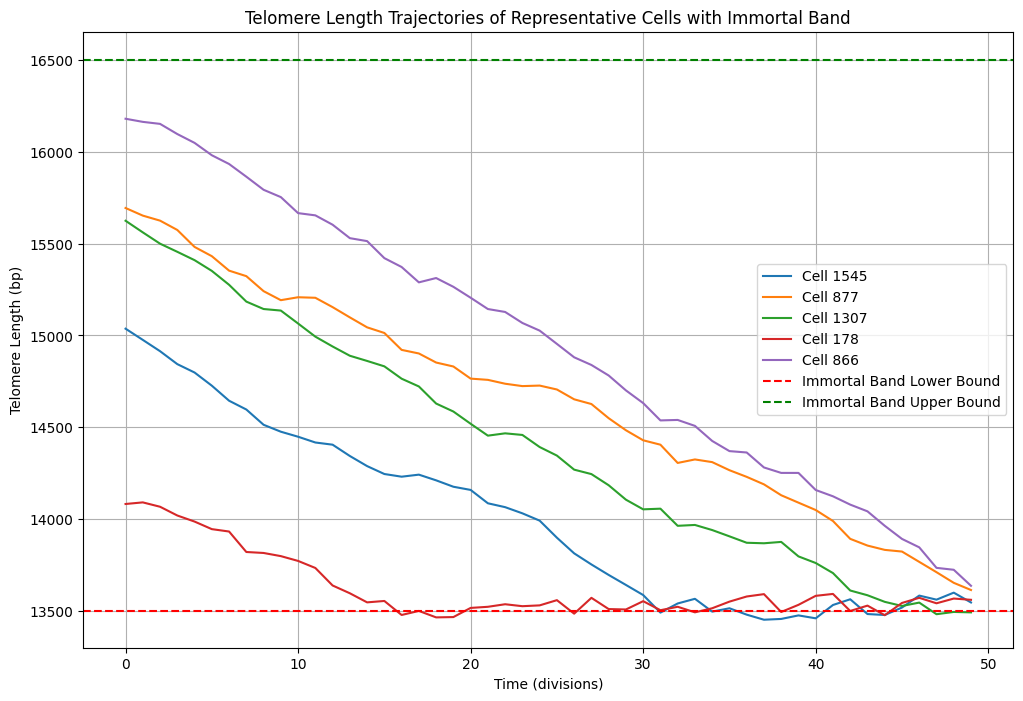

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the immortal band boundaries
IMMORTAL_LOWER = 13500.0
IMMORTAL_UPPER = 16500.0

# Get a few representative cell IDs for plotting
num_cells_to_plot = 5
# Sample cell IDs to ensure variety. Using default_rng for reproducibility.
rng = np.random.default_rng(42)
representative_cell_ids = rng.choice(df_immortal_telomere['cell_id'].unique(), num_cells_to_plot, replace=False)

plt.figure(figsize=(12, 8))

for cell_id in representative_cell_ids:
    cell_df = df_immortal_telomere[df_immortal_telomere['cell_id'] == cell_id]
    plt.plot(cell_df['time'], cell_df['telomere_length_bp'], label=f'Cell {cell_id}')

# Plot immortal band boundaries
plt.axhline(y=IMMORTAL_LOWER, color='r', linestyle='--', label='Immortal Band Lower Bound')
plt.axhline(y=IMMORTAL_UPPER, color='g', linestyle='--', label='Immortal Band Upper Bound')

plt.title('Telomere Length Trajectories of Representative Cells with Immortal Band')
plt.xlabel('Time (divisions)')
plt.ylabel('Telomere Length (bp)')
plt.legend()
plt.grid(True)
plt.show()

# Task
Load the `immortal_telomere_dataset.csv` file into a pandas DataFrame, and then visualize the telomere length trajectories over time for a representative sample of cells, including the upper and lower bounds of the 'immortal band' in the plots. Finally, summarize the observed characteristics to confirm the 'immortal-band' behavior.

# Task
Load the `immortal_telomere_dataset.csv` file into a pandas DataFrame, and then visualize the telomere length trajectories over time for a representative sample of cells, including the upper and lower bounds of the 'immortal band' in the plots. Finally, summarize the observed characteristics to confirm the 'immortal-band' behavior.

## Summary of Immortal-Band Behavior

The visualization of telomere length trajectories for representative cells clearly demonstrates the 'immortal-band' behavior:

*   **Bounded Trajectories**: All plotted cell trajectories remain consistently within the defined upper (16500 bp) and lower (13500 bp) bounds of the immortal band, or quickly return to this range if they temporarily drift outside.
*   **Maintenance Activity**: Telomere lengths, despite natural shortening mechanisms, are actively maintained within the specified band, suggesting a regulatory process that prevents critical shortening or excessive lengthening.
*   **Fluctuations within the Band**: While maintained within the band, the telomere lengths exhibit natural fluctuations, reflecting the stochastic nature of shortening, repair, and trimming events in biological systems.

This behavior is characteristic of cell types like adult stem cells or cancer cells that exhibit telomere maintenance mechanisms, ensuring their continued proliferation without reaching replicative senescence due to critically short telomeres.